In [1]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
import statsmodels.api as sm
from autograd import grad
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from termcolor import colored
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.svm import LinearSVC
from termcolor import colored
from datetime import datetime
import os
import similaritymeasures
import tslearn
from tslearn.metrics import dtw
from scipy.spatial.distance import directed_hausdorff
from frechetdist import frdist
import trjtrypy as tt
from trjtrypy.distances import d_Q
from trjtrypy.distances import d_Q_pi
import trjtrypy.visualizations as vs
from scipy.spatial import distance
from trjtrypy.featureMappings import curve2vec

In [2]:
I = glob.glob('T-Drive/**/*.txt', recursive=True)

In [3]:
# runtime about 35s
Start_time = time.time()
J = [0] * len(I)

for i in range(len(I)):
    for j in range(len(I)):
        if int(I[j][28:-4]) == i+1:
            J[i] = I[j]
print('total time =', time.time() - Start_time)

total time = 37.63029599189758


In [4]:
taxi_id = np.array([J[i][28:-4] for i in range(len(J))])
I = np.sort(list(map(int, taxi_id)))
True in I == list(map(int, taxi_id)) # so the taxi ids are nn.arange(len(J))

array([ True,  True,  True, ...,  True,  True,  True])

In [5]:
len(J)

10357

In [6]:
# create 'daysDate' function to convert start and end time to a float number of days

def days_date(time_str):
    date_format = "%Y-%m-%d %H:%M:%S"
    current = datetime.strptime(time_str, date_format)
    date_format = "%Y-%m-%d"
    bench = datetime.strptime('2006-12-30', date_format)
    no_days = current - bench
    delta_time_days = no_days.days + current.hour / 24.0 + current.minute / (24. * 60.) + current.second / (24. * 3600.)
    return delta_time_days

days_date = np.vectorize(days_date)
float1 = np.vectorize(float)

In [7]:
def read_file(file_name):
    data = []
    f = open(file_name, "r")
    for line in f:
        item = line.strip().split(",")
        if len(item) ==4:
            data.append(np.asarray(item[1:]))
    data = np.array(data)
    return data

## Remove stationary points

In [8]:
def remove_segments(traj): # removes stationary points
    p2 = traj[:,1:][1:]
    p1 = traj[:,1:][:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

### In data1 below:
    (1) there is no stationary points
    (2) there is no trajectories with less than 1 or more than 200 waypoints

In [9]:
# runtime about 350s
Start_time = time.time()
T = len(J)
data1 = [] 
taxi_ids = []
for i in range(T):
    a = read_file(J[i])
    if len(a) > 1000:  
        a[:,0] = days_date(a[:,0])
        a = float1(a)
        data1.append(remove_segments(a)) 
        taxi_ids.append(i)

taxi_ids = np.array(taxi_ids)   
data1 = np.array(data1, dtype='object')
I = np.where(np.array([len(data1[i]) for i in range(len(data1))]) > 0)[0]
data1 = data1[I]
taxi_ids = np.array(taxi_ids[I], dtype='object')
print('total time =', time.time() - Start_time)
print("len(data1) =", len(data1))
print("selected taxi_ids: \n", taxi_ids)

total time = 352.83437275886536
len(data1) = 6611
selected taxi_ids: 
 [1 2 9 ... 10339 10350 10353]


In [10]:
def partition(trajectory, threshold=20):
    trajectories = []
    a = 24 * 60 * (trajectory[-1][0] - trajectory[0][0])
    if a <= threshold:
        return np.array(trajectory.reshape(1, len(trajectory), 3))
    else: 
        i = 0
        while a > threshold:
            j = i + 0
            val = 0
            while val < threshold: 
                if i < len(trajectory) - 1:
                    temp = val + 0
                    val += 24 * 60 * (trajectory[:,0][1:][i] - trajectory[:,0][:-1][i])
                    i += 1
                else: 
                    break
            if len(trajectory[j:i-1]) > 0:
                trajectories.append(trajectory[j:i-1])
            a = a - val
        if len(trajectory[i:]) > 0:
            trajectories.append(trajectory[i:])
    trajectories = np.array(trajectories, dtype='object')
    return trajectories

In [11]:
# Check to see if partitioning into less than 20 minutes worked correctly
for j in range(len(data1)):
    A = partition(data1[j], threshold=20)
    B = np.array([24 * 60 * (A[i][-1][0] - A[i][0][0]) for i in range(len(A))], dtype='object')
    I = np.where(B > 800)[0]
    if len(I) > 0: 
        print(j)

### In data3 below 
    1) any taxi has between 100 and 200 trajectories
    2) in each taxi dataset any trajectory has less than 20 minutes time

In [12]:
Start_time = time.time()
data3 = []
idxs = []
for i in range(len(data1)):
    D = []
    A = partition(data1[i], threshold=20)
    for j in range(len(A)):
        if ((len(A[j]) >= 10) and (len(A[j]) <= 200)):
            D.append(A[j])
    if (len(D) >= 100 and len(D) <= 200):
        data3.append(np.array(D, dtype='object'))
        idxs.append(i)

taxi_idxs = taxi_ids[idxs]
data3 = np.array(data3, dtype='object')
taxi_idxs = np.array(taxi_idxs)

print('total time =', time.time() - Start_time)
print("len(data3) =", len(data3))
print("len(taxi_idxs) =", len(taxi_idxs))

A = np.array([len(data3[i]) for i in range(len(data3))])
print(colored(f"min and max length of selected users: {min(A), max(A)}", "green"))

print("number of selected users:", len(data3))
print("idxs: \n", idxs)
print(colored(f"selected taxi ids: \n {taxi_idxs}", "blue"))

total time = 26.36145806312561
len(data3) = 433
len(taxi_idxs) = 433
min and max length of selected users: (100, 200)
number of selected users: 433
idxs: 
 [2, 4, 16, 17, 18, 75, 76, 97, 137, 333, 504, 505, 542, 558, 559, 561, 571, 572, 573, 587, 595, 597, 601, 612, 620, 636, 667, 727, 753, 897, 910, 923, 926, 933, 939, 940, 942, 945, 947, 972, 989, 1007, 1034, 1036, 1047, 1060, 1063, 1066, 1067, 1069, 1076, 1161, 1174, 1181, 1189, 1190, 1195, 1197, 1208, 1210, 1212, 1215, 1217, 1218, 1224, 1229, 1231, 1240, 1244, 1246, 1249, 1250, 1257, 1269, 1280, 1292, 1294, 1299, 1300, 1304, 1307, 1310, 1405, 1421, 1422, 1423, 1429, 1435, 1439, 1440, 1443, 1469, 1477, 1488, 1490, 1499, 1519, 1531, 1540, 1544, 1551, 1562, 1618, 1622, 1642, 1643, 1670, 1674, 1676, 1677, 1679, 1680, 1690, 1701, 1702, 1708, 1717, 1745, 1847, 1849, 1855, 1858, 1859, 1860, 1865, 1881, 1882, 1883, 1894, 1895, 1897, 1902, 1907, 1914, 1929, 2025, 2059, 2070, 2126, 2127, 2237, 2299, 2300, 2349, 2364, 2374, 2375, 2378, 2437, 

In [14]:
data = data3
Min = np.min([np.min([np.min(data[i][j][:,1:], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Max = np.max([np.max([np.max(data[i][j][:,1:], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Mean = np.mean([np.mean([np.mean(data[i][j][:,1:], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Std = np.std([np.std([np.std(data[i][j][:,1:], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Min, Mean, Max, Std

(array([0., 0.]),
 array([116.40009395,  39.92449853]),
 array([127.79612,  53.0025 ]),
 array([0.97710344, 0.33774151]))

In [15]:
pairs = []
for i in range(len(data)-1):
    for j in range(i+1, len(data)):
        pairs.append([i,j])
pairs = np.array(pairs)
print(len(pairs))

93528


In [16]:
#I = np.arange(len(pairs))
#np.random.shuffle(I)
#pairs_100 = pairs[I[:100]]
# we did above and chose the following pairs
pairs_100 = np.array([[ 87, 166], [161, 396], [370, 425], [209, 421], [ 84, 278], 
                      [ 24,  95], [ 72, 249], [358, 419], [ 86, 382], [241, 297],
                      [315, 363], [273, 335], [118, 270], [323, 430], [ 30, 431],
                      [111, 297], [ 17, 103], [191, 210], [179, 240], [ 53, 139],
                      [156, 240], [128, 412], [  8, 166], [ 96,  98], [270, 303],
                      [160, 319], [ 17,  41], [ 46, 381], [165, 216], [  8, 148],
                      [231, 287], [293, 426], [131, 264], [136, 271], [ 69, 137],
                      [120, 139], [111, 261], [ 13, 114], [138, 291], [ 31, 414], 
                      [252, 276], [ 38, 126], [ 31, 243], [382, 417], [240, 262],
                      [ 45,  49], [313, 359], [107, 206], [212, 243], [ 91, 383],
                      [118, 402], [ 31, 355], [ 74, 365], [110, 132], [136, 330],
                      [326, 376], [ 28, 128], [258, 302], [193, 256], [ 48, 151],
                      [255, 309], [340, 391], [ 90, 216], [341, 400], [ 45, 296], 
                      [206, 370], [184, 379], [248, 343], [ 16, 271], [245, 401],
                      [ 25, 130], [ 15, 430], [ 20, 285], [362, 385], [192, 343], 
                      [111, 410], [400, 414], [116, 185], [ 48, 202], [ 85, 234], 
                      [281, 392], [318, 320], [ 85, 417], [390, 427], [357, 428], 
                      [150, 189], [ 40, 343], [173, 249], [ 38, 399], [121, 393], 
                      [152, 316], [  0, 141], [ 24, 397], [255, 424], [ 92, 330], 
                      [121, 245], [ 78, 240], [ 68, 255], [ 21, 288], [278, 399]])

In [18]:
taxi_ids_selected = list(set(pairs_100.reshape(200,)))
print("Chosen Users: \n", taxi_ids_selected)

Chosen Users: 
 [0, 8, 13, 15, 16, 17, 20, 21, 24, 25, 28, 30, 31, 38, 40, 41, 45, 46, 48, 49, 53, 68, 69, 72, 74, 78, 84, 85, 86, 87, 90, 91, 92, 95, 96, 98, 103, 107, 110, 111, 114, 116, 118, 120, 121, 126, 128, 130, 131, 132, 136, 137, 138, 139, 141, 148, 150, 151, 152, 156, 160, 161, 165, 166, 173, 179, 184, 185, 189, 191, 192, 193, 202, 206, 209, 210, 212, 216, 231, 234, 240, 241, 243, 245, 248, 249, 252, 255, 256, 258, 261, 262, 264, 270, 271, 273, 276, 278, 281, 285, 287, 288, 291, 293, 296, 297, 302, 303, 309, 313, 315, 316, 318, 319, 320, 323, 326, 330, 335, 340, 341, 343, 355, 357, 358, 359, 362, 363, 365, 370, 376, 379, 381, 382, 383, 385, 390, 391, 392, 393, 396, 397, 399, 400, 401, 402, 410, 412, 414, 417, 419, 421, 424, 425, 426, 427, 428, 430, 431]


In [19]:
print("Chosen Users From Data:")
taxi_idxs[taxi_ids_selected] + 1

Chosen Users From Data:


array([10, 251, 817, 820, 839, 841, 875, 877, 919, 947, 1112, 1327, 1350,
       1378, 1439, 1466, 1557, 1563, 1567, 1570, 1725, 1825, 1830, 1847,
       1909, 1950, 2127, 2128, 2138, 2146, 2157, 2193, 2205, 2240, 2274,
       2313, 2454, 2550, 2566, 2567, 2594, 2617, 2862, 2876, 2880, 2909,
       2924, 2927, 2938, 2943, 3142, 3154, 3259, 3260, 3511, 3772, 3866,
       3872, 3896, 3939, 3953, 3954, 3965, 3968, 4312, 4393, 4415, 4452,
       4527, 4580, 4582, 4590, 4730, 4830, 4854, 4875, 4889, 4969, 5415,
       5605, 5896, 5921, 5970, 6168, 6274, 6286, 6361, 6427, 6464, 6569,
       6611, 6623, 6652, 6790, 6834, 6876, 6899, 6908, 6970, 6997, 7008,
       7016, 7133, 7139, 7193, 7199, 7347, 7376, 7411, 7434, 7467, 7469,
       7624, 7653, 7674, 7790, 7840, 7971, 8063, 8260, 8275, 8367, 8654,
       8672, 8676, 8696, 8731, 8736, 8764, 8833, 9186, 9241, 9275, 9278,
       9290, 9316, 9354, 9356, 9368, 9395, 9438, 9468, 9481, 9500, 9513,
       9525, 9788, 9812, 9837, 9946, 10012, 10082,

In [20]:
data = data[taxi_ids_selected]
data.shape

(159,)

In [21]:
Dict = {taxi_ids_selected[i]:i for i in range(len(taxi_ids_selected))} 
pairs_new = []
for pair in pairs_100:
    pairs_new.append([Dict[pair[0]], Dict[pair[1]]])
pairs_new

[[29, 63],
 [61, 140],
 [129, 153],
 [74, 151],
 [26, 97],
 [8, 33],
 [23, 85],
 [124, 150],
 [28, 133],
 [81, 105],
 [110, 127],
 [95, 118],
 [42, 93],
 [115, 157],
 [11, 158],
 [39, 105],
 [5, 36],
 [69, 75],
 [65, 80],
 [20, 53],
 [59, 80],
 [46, 147],
 [1, 63],
 [34, 35],
 [93, 107],
 [60, 113],
 [5, 15],
 [17, 132],
 [62, 77],
 [1, 55],
 [78, 100],
 [103, 154],
 [48, 92],
 [50, 94],
 [22, 51],
 [43, 53],
 [39, 90],
 [2, 40],
 [52, 102],
 [12, 148],
 [86, 96],
 [13, 45],
 [12, 82],
 [133, 149],
 [80, 91],
 [16, 19],
 [109, 125],
 [37, 73],
 [76, 82],
 [31, 134],
 [42, 145],
 [12, 122],
 [24, 128],
 [38, 49],
 [50, 117],
 [116, 130],
 [10, 46],
 [89, 106],
 [71, 88],
 [18, 57],
 [87, 108],
 [119, 137],
 [30, 77],
 [120, 143],
 [16, 104],
 [73, 129],
 [66, 131],
 [84, 121],
 [4, 94],
 [83, 144],
 [9, 47],
 [3, 157],
 [6, 99],
 [126, 135],
 [70, 121],
 [39, 146],
 [143, 148],
 [41, 67],
 [18, 72],
 [27, 79],
 [98, 138],
 [112, 114],
 [27, 149],
 [136, 155],
 [123, 156],
 [56, 68],
 [1

In [22]:
data_with_time = data + 0

In [23]:
for i in range(len(data)):
    for j in range(len(data[i])):
        data[i][j] = data[i][j][:,1:]

In [24]:
Min = np.min([np.min([np.min(data[i][j], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Max = np.max([np.max([np.max(data[i][j], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Mean = np.mean([np.mean([np.mean(data[i][j], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Std = np.std([np.std([np.std(data[i][j], 0) for j in range(len(data[i]))], 0) for i in range(len(data))], 0)
Min, Mean, Max, Std, LA.norm(Max - Mean)

(array([0., 0.]),
 array([116.40432008,  39.92667049]),
 array([127.79612,  53.0025 ]),
 array([0.88903461, 0.30846359]),
 17.34215738681324)

In [25]:
interesting_idx = []
for i in range(len(data)):
    I = np.where(np.array([np.min(data[i][j][:,0]) for j in range(len(data[i]))]) < 20)[0]
    if len(I) > 0:
        interesting_idx.append(i)
        
print(interesting_idx)

[10, 21, 28, 35, 76, 84, 85, 86, 93, 96, 97, 102, 108, 115, 117, 124, 149]


In [26]:
print("Final Chosen Users From Data:")
taxi_idxs[taxi_ids_selected][interesting_idx] + 1

Final Chosen Users From Data:


array([1112, 1825, 2138, 2313, 4889, 6274, 6286, 6361, 6790, 6899, 6908,
       7133, 7411, 7790, 7971, 8676, 9946], dtype=object)

In [27]:
for i in interesting_idx:
    print(i, set([len(data[i][j]) for j in range(len(data[i]))]))

10 {10, 11, 12, 13, 18}
21 {10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 54, 55, 56, 58, 59, 60, 61, 63, 66, 67, 75, 77, 81, 82}
28 {12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 59, 61, 62, 65, 66, 76}
35 {11, 14, 15, 16, 18, 19, 20, 23, 24, 26, 28, 29, 32, 33, 34, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 87, 91, 92, 95, 96, 100, 101, 102, 120, 126}
76 {10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 58, 59, 60, 61, 70}
84 {10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,

# Classifiers

In [168]:
CC = [100, 100, 1000]
number_estimators = 50

clf1 = [make_pipeline(LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "SVM, LinearSVC, C = "+str(CC[0])]
clf2 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[1], kernel='rbf', gamma='auto', max_iter=200000)),
        "Gaussian SVM, C="+str(CC[1])+", gamma=auto"]
clf3 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[2], kernel='poly', degree=3, max_iter=400000)),
        "Poly kernel SVM, C="+str(CC[2])+", deg=auto"]
clf4 = [DecisionTreeClassifier(), "Decision Tree"]
clf5 = [RandomForestClassifier(n_estimators=number_estimators), 
         "RandomForestClassifier, n="+str(number_estimators)]
clf6 = [KNeighborsClassifier(n_neighbors=5), "KNN"]
clf7 = [LogisticRegression(solver='lbfgs'), "Logistic Regression"]

clf = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]

classifs = [item[0] for item in clf]
keys = [item[1] for item in clf]

In [27]:
pairs_errors = []
i = 0
for pair in pairs_new:
    A = classification_without_exp_random_Q(data[pair[0]], data[pair[1]], Q_size=20, 
                                            epoch=100, classifiers=[clf7])
    pairs_errors.append([pair, np.round(A[-1][0], decimals=2)])
    print('i =', i)
    print(colored(f"pair={pair}", 'green'))
    print(A[0])
    print("===================================================================")
    i += 1

total time = 9.3976309299469
i = 0
pair=[29, 63]
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0005      0.1795     0.0378
total time = 10.600561141967773
i = 1
pair=[61, 140]
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0005      0.2851     0.0421
total time = 10.537057161331177
i = 2
pair=[129, 153]
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0005      0.2505     0.0467
total time = 11.264155864715576
i = 3
pair=[74, 151]
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0002      0.2038     0.0354
total time = 12.360167264938354
i = 4
pair=[26, 97]
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0008      0.1374     0.0286
total time = 12.210195064544678
i = 5
pair=[8, 33]
        

In [32]:
print(f"selected 1oo random pairs of taxies in T-Drive dataset: \n {pairs_100.tolist()}")
print(f"selected random 100 pairs of taxies in data dataset: \n {pairs_new}")
#selected_pairs_of_taxies = 

selected 1oo random pairs of taxies in T-Drive dataset: 
 [[87, 166], [161, 396], [370, 425], [209, 421], [84, 278], [24, 95], [72, 249], [358, 419], [86, 382], [241, 297], [315, 363], [273, 335], [118, 270], [323, 430], [30, 431], [111, 297], [17, 103], [191, 210], [179, 240], [53, 139], [156, 240], [128, 412], [8, 166], [96, 98], [270, 303], [160, 319], [17, 41], [46, 381], [165, 216], [8, 148], [231, 287], [293, 426], [131, 264], [136, 271], [69, 137], [120, 139], [111, 261], [13, 114], [138, 291], [31, 414], [252, 276], [38, 126], [31, 243], [382, 417], [240, 262], [45, 49], [313, 359], [107, 206], [212, 243], [91, 383], [118, 402], [31, 355], [74, 365], [110, 132], [136, 330], [326, 376], [28, 128], [258, 302], [193, 256], [48, 151], [255, 309], [340, 391], [90, 216], [341, 400], [45, 296], [206, 370], [184, 379], [248, 343], [16, 271], [245, 401], [25, 130], [15, 430], [20, 285], [362, 385], [192, 343], [111, 410], [400, 414], [116, 185], [48, 202], [85, 234], [281, 392], [318, 3

### The following two boxes are for above 0.20 test error that newly are done

In [38]:
pairs_100 = np.array(pairs_new, dtype='object') + 0

# Generating distance matrices

## $d_Q^{\pi}$

In [85]:
def calculate_dists_d_Q_pi(data1, data2, p, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(d_Q_pi(Q, data[i], data[j], p=p))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [ ]:
# the following path is for 100 chosen pairs for correlation and R^2 test
paths = []
for i in range(len(pairs_100)): 
    paths.append('Calculated Distance Matrices for KNN for comparison with RF/Taxi/d_Q_pi/Taxi-Pairs['+str(pairs_100[i])+']-d_Q_pi.csv')

for i in range(len(pairs_100)):
    calculate_dists_d_Q_pi(data[pairs_100[i][0]], data[pairs_100[i][1]], p=1, path=paths[i])


In [40]:
def KNN_with_d_Q_pi(n_1, n_2, dist_matrix):
    
    '''path example: '/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN/Taxi-Pairs['+str(pairs_final[i])+']-d_Q_pi.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [41]:
def KNN_average_error_d_Q_pi(data1, data2, num_trials, path_to_dists, pair):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)
    
    dist_matrix = np.array(pd.read_csv(path_to_dists, header=None))

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_d_Q_pi(len(data1), len(data2), dist_matrix)

    Dict = {}
    Dict[1] = [f"KNN with d_Q_pi for pairs {pair}", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.median(test_errors), 
            np.std(test_errors))

In [ ]:
## the following path is for 100 chosen pairs for correlation and R^2 test
paths = []
for i in range(len(pairs_100)):
    paths.append('/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN for comparison with RF/Taxi/d_Q_pi/Taxi-Pairs['+str(pairs_100[i])+']-d_Q_pi.csv')

train_test_median_std_errors_d_Q_pi = []
for i in range(len(pairs_100)):
    print("i=", i)
    print(colored(f"pair: {pairs_100[i]}", 'magenta'))
    A = KNN_average_error_d_Q_pi(data[pairs_100[i][0]], data[pairs_100[i][1]], 
                                 num_trials=100, path_to_dists=paths[i], pair=pairs_100[i])
    train_test_median_std_errors_d_Q_pi.append(A[1:])
    print(A[0])
    print("=======================================================================")

In [679]:
path = '/Users/hasan/Desktop/Anaconda/Research/Calculated KNN errors for comparison with RF/Taxi-Pairs-d_Q_pi.csv'
np.savetxt(path, np.array(train_test_median_std_errors_d_Q_pi), delimiter=',')


## dtw from tslearn

In [42]:
def calculate_dists_dtw_tslearn(data1, data2, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(tslearn.metrics.dtw(data[i], data[j]))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [180]:
# the following path is for 100 chosen pairs for correlation and R^2 test
paths = []
for i in range(len(pairs_100)): 
    paths.append('/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN for comparison with RF/dtw_tslearn/Taxi/Taxi-Pairs['+str(pairs_100[i])+']-dtw-tslearn.csv')

for i in range(len(pairs_100)):
    calculate_dists_dtw_tslearn(data[pairs_100[i][0]], data[pairs_100[i][1]], path=paths[i])
    

In [43]:
def KNN_with_dists_dtw_tslearn(n_1, n_2, path_to_dists):
    '''path example: '/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN/Taxi-Pairs['+str(pairs_final[i])+']-dtw-tslearn.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)
    dist_matrix = np.array(pd.read_csv(path_to_dists,  header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [44]:
def KNN_average_error_dtw_tslearn(data1, data2, num_trials, path_to_dists, pair):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists_dtw_tslearn(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with dtw from tslearn for pairs {pair}", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.median(test_errors), 
            np.std(test_errors))

In [ ]:
# # the following path is for 100 chosen pairs for correlation and R^2 test
paths = []
for i in range(len(pairs_100)):
    paths.append('/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN for comparison with RF/Taxi/dtw_tslearn/Taxi-Pairs['+str(pairs_100[i])+']-dtw-tslearn.csv')

train_test_median_std_errors_dtw_tslearn = []
for i in range(len(pairs_100)):
    print("i=", i)
    print(colored(f"pair: {pairs_100[i]}", 'magenta'))
    A = KNN_average_error_dtw_tslearn(data[pairs_100[i][0]], data[pairs_100[i][1]], num_trials=100, 
                            path_to_dists=paths[i], pair=pairs_100[i])
    train_test_median_std_errors_dtw_tslearn.append(A[1:])
    print(A[0])
    print("=====================================================================")

In [364]:
path = '/Users/hasan/Desktop/Anaconda/Research/Calculated KNN errors for comparison with RF/Taxi-Pairs-dtw_tslearn.csv'
np.savetxt(path, np.array(train_test_median_std_errors_dtw_tslearn), delimiter=',')


## From github page: https://github.com/bguillouet/traj-dist

It includes 9 distances for trajectories including: Continuous Frechet, Discrete Frechet, Hausdorff, DTW, SSPD, LCSS, EDR, ERP.

## All but the continuous Frechet distance are really fast.

In [301]:
import traj_dist.distance as tdist
import pickle

In [45]:
def KNN_with_dists(n_1, n_2, dists_names, paths_to_dists):
    '''path example: '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/sspd.csv'
       dists_names: a list of distance names
       paths_to_dists: the paths list to the corresponding distancas (each path 
                       points out to the corresponding distance matrix)
       n_1: len(data_1)
       n_2: len(data_2)
       dist_name: the name of distance used to calculate sitance matrix 
       (the name is taken from a list above called metrics)'''

    train_errors = np.zeros(len(dists_names))
    test_errors = np.zeros(len(dists_names))

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1]*n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    for i in range(len(dists_names)):

        dist_matrix = np.array(pd.read_csv(paths_to_dists[i], header=None))

        D_train = dist_matrix[I][:, I]
        D_test = dist_matrix[J][:,I]
        train_labels = labels[I]
        test_labels = labels[J]

        clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
        
        #Train the model using the training sets
        clf.fit(D_train, list(train_labels))

        #Predict labels for train dataset
        train_pred = clf.predict(D_train)
        train_errors[i] = sum(train_labels != train_pred)/len(I)
        
        #Predict labels for test dataset
        test_pred = clf.predict(D_test)
        test_errors[i] = sum((test_labels != test_pred))/len(J)
        
    return train_errors, test_errors

In [46]:
def KNN_average_error_7_dists(data1, data2, num_trials, dists_names, paths_to_dists):

    '''dists_names: a list of distance names
       paths_to_dists: the paths list to the corresponding distancas (each path 
                       points out to the corresponding distance matrix)'''

    Start_time = time.time()

    train_errors = np.zeros((num_trials, len(dists_names)))
    test_errors = np.zeros((num_trials, len(dists_names)))

    for i in range(num_trials):
        tr_errors, ts_errors = KNN_with_dists(len(data1), len(data2), dists_names, paths_to_dists)
        train_errors[i] = tr_errors
        test_errors[i] = ts_errors

    train_error = np.mean(train_errors, axis=0)
    test_error = np.mean(test_errors, axis=0)
    std_test_error = np.std(test_errors, axis=0)

    Dict = {}
    for i in range(len(dists_names)):
        Dict[i+1] = [f"KNN with {dists_names[i]}", 
                     np.round(train_error[i], decimals = 4), 
                     np.round(test_error[i], decimals = 4), 
                     np.round(std_test_error[i], decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return [df, train_errors, test_errors, train_error, test_error, 
            np.median(test_errors, axis=0), np.std(test_errors, axis=0)]

In [302]:
# For 100 pairs
Metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'lcss', 'edr', 'erp']

#tdist.pdist(data[pairs_100[5][1]][:10], 'edr', eps=1e-10) 
#tdist.pdist(data[pairs_100[5][1]][:10], 'lcss', eps=0.05) 

for i in range(len(pairs_100)):
    st_time = time.time()
    calculate_dists(data, metrics=Metrics, pair=pairs_100[i], eps_edr=1e-10, eps_lcss=0.05)
    print(f"time for {i}-th pair: {time.time() - st_time}")

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/traj_dist-1.1-py3.7-macosx-10.9-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


time for 0-th pair: 19.202829122543335
time for 1-th pair: 11.69206690788269
time for 2-th pair: 19.121741771697998
time for 3-th pair: 27.424561977386475
time for 4-th pair: 36.33103108406067
time for 5-th pair: 56.85395884513855
time for 6-th pair: 28.69072198867798
time for 7-th pair: 12.410237312316895
time for 8-th pair: 14.80678677558899
time for 9-th pair: 54.346762895584106
time for 10-th pair: 31.288318157196045
time for 11-th pair: 26.365992069244385
time for 12-th pair: 31.905056953430176
time for 13-th pair: 15.700203895568848
time for 14-th pair: 8.747708082199097
time for 15-th pair: 22.919544219970703
time for 16-th pair: 22.293619871139526
time for 17-th pair: 35.88955092430115
time for 18-th pair: 29.685508012771606
time for 19-th pair: 7.9671311378479
time for 20-th pair: 23.17397379875183
time for 21-th pair: 9.926188707351685
time for 22-th pair: 5.839998960494995
time for 23-th pair: 25.822988033294678
time for 24-th pair: 60.177436113357544
time for 25-th pair: 32

In [304]:
# the following path is for 100 chosen pairs for correlation and R^2 test
paths = []
for i in range(len(pairs_100)):
    paths_temp = []
    for j in range(len(Metrics)):
        paths_temp.append('Calculated Distance Matrices for KNN for comparison with RF/Taxi/7-dists/Taxi-Pairs'+str(pairs_100[i])+'-'+Metrics[j]+'.csv')
    paths.append(paths_temp)
    
train_test_median_std_errors_7_dists = []
for i in range(len(pairs_100)):
    print("i=", i)
    A = KNN_average_error_7_dists(data[pairs_100[i][0]], data[pairs_100[i][1]], 
                          num_trials=100, dists_names=Metrics, paths_to_dists=paths[i])
    train_test_median_std_errors_7_dists.append(A[3:])
    print(colored(f"pair: {pairs_100[i]}", 'magenta'))
    print(A[0])
    print("============================================================")

i= 0
num_trials = 100
total time = 23.134958028793335
pair: [29 63]
                 Classifier  Train Error  Test Error     std
1  KNN with discret_frechet       0.1448      0.1904  0.0307
2        KNN with hausdorff       0.1445      0.1901  0.0344
3              KNN with dtw       0.1348      0.1919  0.0390
4             KNN with sspd       0.1202      0.1771  0.0354
5             KNN with lcss       0.2532      0.3042  0.0365
6              KNN with edr       0.8121      0.8437  0.0341
7              KNN with erp       0.1024      0.1399  0.0372
i= 1
num_trials = 100
total time = 24.859258890151978
pair: [61 140]
                 Classifier  Train Error  Test Error     std
1  KNN with discret_frechet       0.2173      0.3208  0.0353
2        KNN with hausdorff       0.2045      0.3090  0.0366
3              KNN with dtw       0.2035      0.2819  0.0382
4             KNN with sspd       0.1908      0.2792  0.0413
5             KNN with lcss       0.3121      0.3586  0.0427
6        

In [305]:
train_test_median_std_errors_discret_frechet = np.array(train_test_median_std_errors_7_dists)[:,:,0]
train_test_median_std_errors_hausdorff = np.array(train_test_median_std_errors_7_dists)[:,:,1]
train_test_median_std_errors_dtw = np.array(train_test_median_std_errors_7_dists)[:,:,2]
train_test_median_std_errors_sspd = np.array(train_test_median_std_errors_7_dists)[:,:,3]
train_test_median_std_errors_lcss = np.array(train_test_median_std_errors_7_dists)[:,:,4]
train_test_median_std_errors_edr = np.array(train_test_median_std_errors_7_dists)[:,:,5]
train_test_median_std_errors_erp = np.array(train_test_median_std_errors_7_dists)[:,:,6]

In [306]:
for i in range(len(Metrics)):
    path = '/Users/hasan/Desktop/Anaconda/Research/Calculated KNN errors for comparison with RF/Taxi-Pairs'+'-'+Metrics[i]+'.csv'
    np.savetxt(path, np.array(train_test_median_std_errors_7_dists)[:,:,i], delimiter=',')


## fastdtw which is an approximate dtw

In [77]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def calculate_fastdtw_dists(data1, data2, path): 
    start_time = time.time() 
    X = np.concatenate((data1, data2), 0)
    n = len(X)
    matrix = np.zeros((n, n))
    for i in range(n):
        matrix[i][i:] = [fastdtw(X[i], X[j])[0] for j in range(i, n)]
    for i in range(1, n):
        for j in range(i):
            matrix[i][j] = matrix[j][i]
    np.savetxt(path, matrix, delimiter=',')
    total_time = time.time() - start_time
    return total_time

In [273]:
# the following path is for 100 chosen pairs for correlation and R^2 test
paths = []
for i in range(len(pairs_100)): 
    paths.append('/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN for comparison with RF/Taxi/fastdtw/Taxi/Taxi-Pairs['+str(pairs_100[i])+']-fastdtw.csv')

for i in range(len(pairs_100)):
    calculate_fastdtw_dists(data[pairs_100[i][0]], data[pairs_100[i][1]], path=paths[i])
    

In [66]:
def KNN_with_fastdtw(n_1, n_2, path_to_dists):
    '''n_1: len(data_1)
       n_2: len(data_2)
       dist_name: the name of distance used to calculate sitance matrix 
       (the name is taken from a list above called metrics)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1]*n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)
    dist_matrix = np.array(pd.read_csv(path_to_dists, header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_errors = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_errors = sum((test_labels != test_pred))/len(J)
        
    return train_errors, test_errors

In [67]:
def KNN_fastdtw_average_error(data1, data2, num_trials, path_to_dists, pair):

    '''dists_names: a list of distance names
       paths_to_dists: the paths list to the corresponding distancas (each path 
                       points out to the corresponding distance matrix)'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        tr_errors, ts_errors = KNN_with_fastdtw(len(data1), len(data2), path_to_dists)
        train_errors[i] = tr_errors
        test_errors[i] = ts_errors

    train_error = np.mean(train_errors)
    test_error = np.mean(test_errors)
    std_test_error = np.std(test_errors)

    Dict = {}
    Dict[1] = [f"KNN with fastdtw pair {pair}", 
               np.round(train_error, decimals = 4), 
               np.round(test_error, decimals = 4), 
               np.round(std_test_error, decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, train_errors, test_errors, train_error, test_error, 
            np.median(test_errors), np.std(test_errors))

In [ ]:
# the following path is for 100 chosen pairs for correlation and R^2 test
paths = []
for i in range(len(pairs_100)):
    paths.append('Calculated Distance Matrices for KNN for comparison with RF/Taxi/fastdtw/Taxi-Pairs['+str(pairs_100[i])+']-fastdtw.csv')

train_test_median_std_errors_fastdtw = []
for i in range(len(pairs_100)):
    print(colored(f"i = {i}, pair: {pairs_100[i]}", 'magenta'))
    A = KNN_fastdtw_average_error(data[pairs_100[i][0]], data[pairs_100[i][1]], 
                                  num_trials=100, path_to_dists=paths[i], pair=pairs_100[i])
    train_test_median_std_errors_fastdtw.append(A[3:])
    print(A[0])
    print("=====================================================================")

In [284]:
path = '/Users/hasan/Desktop/Anaconda/Research/Calculated KNN errors for comparison with RF/Taxi-Pairs-fastdtw.csv'
np.savetxt(path, np.array(train_test_median_std_errors_fastdtw), delimiter=',')


## Soft-dtw

In [43]:
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

def calculate_dists_soft_dtw(data1, data2, gamma, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            D = SquaredEuclidean(data[i], data[j])
            sdtw = SoftDTW(D, gamma=gamma)
            A.append(sdtw.compute())
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')
    total_time = time.time() - start_time
    return total_time

In [ ]:
# the following path is for 100 chosen pairs for correlation and R^2 test
paths = []
for i in range(len(pairs_100)): 
    paths.append('Calculated Distance Matrices for KNN for comparison with RF/Taxi/soft-dtw/Taxi/Taxi-Pairs['+str(pairs_100[i])+']-soft-dtw.csv')

for i in range(len(pairs_100)):
    calculate_dists_soft_dtw(data[pairs_100[i][0]], data[pairs_100[i][1]], 
                             gamma=1e-14, path=paths[i])
    

In [45]:
def KNN_with_dists_soft_dtw(n_1, n_2, path_to_dists):
    '''path example: path = '/Users/hasan/Desktop/Anaconda/Research/Calculated Distance Matrices for KNN/Characters-Pairs['+str(i)+']-soft-dtw.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    dist_matrix = np.array(pd.read_csv(path_to_dists,  header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [46]:
def KNN_average_error_soft_dtw(data1, data2, num_trials, path_to_dists, pair):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists_soft_dtw(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with soft-dtw for pairs {pair}", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.median(test_errors), 
            np.std(test_errors))

In [ ]:
# the following path is for 100 chosen pairs for correlation and R^2 test
paths = []
for i in range(len(pairs_100)):
    paths.append('Calculated Distance Matrices for KNN for comparison with RF/Taxi/soft-dtw/Taxi-Pairs['+str(pairs_100[i])+']-soft-dtw.csv')

train_test_median_std_errors_soft_dtw = []
for i in range(len(pairs_100)):
    print("i=", i)
    print(colored(f"pair: {pairs_100[i]}", 'magenta'))
    A = KNN_average_error_soft_dtw(data[pairs_100[i][0]], data[pairs_100[i][1]], 
                                              num_trials=100, path_to_dists=paths[i], 
                                              pair=pairs_100[i])
    train_test_median_std_errors_soft_dtw.append(A[1:])
    print(A[0])
    print("=====================================================================")

In [300]:
path = '/Users/hasan/Desktop/Anaconda/Research/Calculated KNN errors for comparison with RF/Taxi-Pairs-soft_dtw.csv'
np.savetxt(path, np.array(train_test_median_std_errors_soft_dtw), delimiter=',')


# Correlation

In [31]:
pairs_100 = pairs_new

## Classification of pairs_100 with $v_Q$ with random $Q$ in each iteration

In [327]:
clfs = clff[1:2] + clff[6:7] + clff[9:12] + clff[:1] + clff[13:]
v_Q_errors_100 = []
v_Q_stds_100 = []

for pair in pairs_100:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=100, num_trials_maj=1, classifiers=clfs, 
                                            version='unsigned', test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_errors_100.append(np.round(A[2], decimals=4).tolist())
    v_Q_stds_100.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_errors_100 = \n', v_Q_errors_100)
print('v_Q_stds_100 = \n', v_Q_stds_100)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_errors_100, 0), decimals=4))}', 'blue'))
print(colored(f'average stds: {list(np.round(np.mean(v_Q_stds_100, 0), decimals=4))}', 'green'))

np.savetxt('Claculated test errors for correlation/Taxi/random_V_Q_errors.csv', v_Q_errors_100, 
           delimiter=',')
np.savetxt('Claculated test errors for correlation/Taxi/random_V_Q_stds.csv', v_Q_stds_100, 
           delimiter=',')

pair=[29 63]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 21.110087871551514
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1563      0.1867     0.0400
2   Gaussian SVM, C = 100, gamma =auto       0.0934      0.1777     0.0399
3  Poly kernel SVM, C = 1000, deg=auto       0.0889      0.1881     0.0474
4                        Decision Tree       0.0000      0.2267     0.0467
5         RandomForestClassifier, n=50       0.0005      0.1876     0.0414
6                                  KNN       0.1410      0.2061     0.0479
7                  Logistic Regression       0.2408      0.2490     0.0468
8                           Perceptron       0.2811      0.2900     0.0989
pair=[61 140]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 24.03730607032776
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2809      0.3104     0.0410
2   Gaussian SVM, C = 100, gamma =auto       0.1707      0.2751     0.0396
3  Poly kernel SVM, C = 1000, deg=auto       0.1594      0.2677     0.0479
4                        Decision Tree       0.0000      0.3514     0.0450
5         RandomForestClassifier, n=50       0.0007      0.2931     0.0420
6                                  KNN       0.2036      0.2840     0.0463
7                  Logistic Regression       0.3487      0.3537     0.0422
8                           Perceptron       0.3877      0.3960     0.0883
pair=[129 153]
total time = 19.023495197296143
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2360      0.2705     0.0497
2   Gaussian SVM, C = 100, gamma =auto       0.1539      0.2547     0.0461
3  Poly kernel SVM, C 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 22.053977966308594
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1311      0.1487     0.0299
2   Gaussian SVM, C = 100, gamma =auto       0.0883      0.1328     0.0299
3  Poly kernel SVM, C = 1000, deg=auto       0.1254      0.1800     0.0439
4                        Decision Tree       0.0000      0.1834     0.0363
5         RandomForestClassifier, n=50       0.0008      0.1367     0.0286
6                                  KNN       0.1113      0.1315     0.0307
7                  Logistic Regression       0.1288      0.1301     0.0324
8                           Perceptron       0.3292      0.3342     0.1460
pair=[8 33]
total time = 20.430388927459717
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0522      0.0645     0.0231
2   Gaussian SVM, C = 100, gamma =auto       0.0284      0.0603     0.0213
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 20.307093858718872
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1010      0.1154     0.0279
2   Gaussian SVM, C = 100, gamma =auto       0.0848      0.1244     0.0314
3  Poly kernel SVM, C = 1000, deg=auto       0.1102      0.1510     0.0399
4                        Decision Tree       0.0000      0.1587     0.0359
5         RandomForestClassifier, n=50       0.0004      0.1121     0.0324
6                                  KNN       0.0948      0.1294     0.0302
7                  Logistic Regression       0.1102      0.1169     0.0292
8                           Perceptron       0.4082      0.4117     0.1542
pair=[124 150]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 17.071659803390503
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0944      0.1059     0.0419
2   Gaussian SVM, C = 100, gamma =auto       0.0367      0.0664     0.0246
3  Poly kernel SVM, C = 1000, deg=auto       0.1156      0.1646     0.0692
4                        Decision Tree       0.0000      0.0664     0.0246
5         RandomForestClassifier, n=50       0.0003      0.0431     0.0217
6                                  KNN       0.0484      0.0669     0.0237
7                  Logistic Regression       0.3113      0.3249     0.0333
8                           Perceptron       0.4937      0.4996     0.1325
pair=[28 133]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incre

total time = 16.232245922088623
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2325      0.2618     0.0604
2   Gaussian SVM, C = 100, gamma =auto       0.1053      0.1839     0.0340
3  Poly kernel SVM, C = 1000, deg=auto       0.1259      0.2155     0.0515
4                        Decision Tree       0.0000      0.2430     0.0457
5         RandomForestClassifier, n=50       0.0006      0.1918     0.0398
6                                  KNN       0.1338      0.1895     0.0468
7                  Logistic Regression       0.2749      0.2783     0.0494
8                           Perceptron       0.4595      0.4600     0.0760
pair=[81 105]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 22.356209993362427
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2248      0.2414     0.0395
2   Gaussian SVM, C = 100, gamma =auto       0.1988      0.2196     0.0349
3  Poly kernel SVM, C = 1000, deg=auto       0.2920      0.3016     0.0618
4                        Decision Tree       0.0000      0.2752     0.0405
5         RandomForestClassifier, n=50       0.0010      0.2301     0.0342
6                                  KNN       0.1637      0.2352     0.0391
7                  Logistic Regression       0.3138      0.3217     0.0569
8                           Perceptron       0.4132      0.4158     0.0866
pair=[110 127]
total time = 20.438241958618164
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2382      0.2666     0.0388
2   Gaussian SVM, C = 100, gamma =auto       0.1718      0.2634     0.0403
3  Poly kernel SVM, C

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 30.253519773483276
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2544      0.2818     0.0387
2   Gaussian SVM, C = 100, gamma =auto       0.1539      0.2813     0.0456
3  Poly kernel SVM, C = 1000, deg=auto       0.1456      0.2891     0.0437
4                        Decision Tree       0.0000      0.3142     0.0461
5         RandomForestClassifier, n=50       0.0005      0.2585     0.0455
6                                  KNN       0.1775      0.2712     0.0450
7                  Logistic Regression       0.3212      0.3332     0.0447
8                           Perceptron       0.3985      0.4023     0.0912
pair=[42 93]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 23.8746018409729
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2616      0.2820     0.0364
2   Gaussian SVM, C = 100, gamma =auto       0.2226      0.2435     0.0417
3  Poly kernel SVM, C = 1000, deg=auto       0.2333      0.2632     0.0405
4                        Decision Tree       0.0000      0.2702     0.0458
5         RandomForestClassifier, n=50       0.0000      0.2355     0.0381
6                                  KNN       0.1544      0.2569     0.0421
7                  Logistic Regression       0.2773      0.2935     0.0359
8                           Perceptron       0.5272      0.5282     0.0279
pair=[115 157]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 20.41504693031311
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2125      0.2426     0.0478
2   Gaussian SVM, C = 100, gamma =auto       0.1547      0.2162     0.0420
3  Poly kernel SVM, C = 1000, deg=auto       0.1972      0.2503     0.0375
4                        Decision Tree       0.0000      0.2657     0.0456
5         RandomForestClassifier, n=50       0.0008      0.2067     0.0411
6                                  KNN       0.1729      0.2421     0.0467
7                  Logistic Regression       0.2131      0.2239     0.0409
8                           Perceptron       0.4825      0.4869     0.0772
pair=[11 158]
total time = 18.15898895263672
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1733      0.1856     0.0388
2   Gaussian SVM, C = 100, gamma =auto       0.1302      0.1765     0.0316
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 19.815227031707764
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1923      0.2045     0.0345
2   Gaussian SVM, C = 100, gamma =auto       0.1254      0.2365     0.0419
3  Poly kernel SVM, C = 1000, deg=auto       0.1062      0.2364     0.0461
4                        Decision Tree       0.0000      0.2444     0.0451
5         RandomForestClassifier, n=50       0.0006      0.2211     0.0396
6                                  KNN       0.1607      0.2312     0.0399
7                  Logistic Regression       0.2541      0.2598     0.0462
8                           Perceptron       0.2467      0.2516     0.0803
pair=[65 80]
total time = 15.811074018478394
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1572      0.1753     0.0415
2   Gaussian SVM, C = 100, gamma =auto       0.1413      0.1683     0.0381
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 19.455754280090332
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3357      0.3581     0.0464
2   Gaussian SVM, C = 100, gamma =auto       0.2664      0.3046     0.0359
3  Poly kernel SVM, C = 1000, deg=auto       0.3018      0.3294     0.0277
4                        Decision Tree       0.0000      0.3505     0.0475
5         RandomForestClassifier, n=50       0.0007      0.3203     0.0425
6                                  KNN       0.2280      0.3322     0.0381
7                  Logistic Regression       0.3363      0.3354     0.0194
8                           Perceptron       0.4217      0.4251     0.1087
pair=[46 147]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 21.16172695159912
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1682      0.1862     0.0368
2   Gaussian SVM, C = 100, gamma =auto       0.1335      0.2083     0.0408
3  Poly kernel SVM, C = 1000, deg=auto       0.1288      0.2186     0.0385
4                        Decision Tree       0.0000      0.2355     0.0470
5         RandomForestClassifier, n=50       0.0004      0.2022     0.0391
6                                  KNN       0.1488      0.2199     0.0422
7                  Logistic Regression       0.2672      0.2771     0.0465
8                           Perceptron       0.2871      0.2912     0.0921
pair=[1 63]
total time = 13.088440179824829
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2207      0.2528     0.0432
2   Gaussian SVM, C = 100, gamma =auto       0.1852      0.2723     0.0464
3  Poly kernel SVM, C = 1

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


total time = 15.703936100006104
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1545      0.1679     0.0318
2   Gaussian SVM, C = 100, gamma =auto       0.0960      0.1942     0.0372
3  Poly kernel SVM, C = 1000, deg=auto       0.1133      0.2042     0.0372
4                        Decision Tree       0.0000      0.2303     0.0408
5         RandomForestClassifier, n=50       0.0006      0.1665     0.0367
6                                  KNN       0.1341      0.1677     0.0383
7                  Logistic Regression       0.1770      0.1785     0.0397
8                           Perceptron       0.4317      0.4377     0.1172
pair=[93 107]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 23.696503162384033
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1666      0.1860     0.0339
2   Gaussian SVM, C = 100, gamma =auto       0.1352      0.1514     0.0317
3  Poly kernel SVM, C = 1000, deg=auto       0.1475      0.1769     0.0373
4                        Decision Tree       0.0000      0.2052     0.0391
5         RandomForestClassifier, n=50       0.0004      0.1630     0.0320
6                                  KNN       0.1276      0.1777     0.0332
7                  Logistic Regression       0.2518      0.2625     0.0676
8                           Perceptron       0.4628      0.4644     0.0443
pair=[60 113]
total time = 19.758842706680298
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1892      0.2153     0.0367
2   Gaussian SVM, C = 100, gamma =auto       0.1245      0.2189     0.0377
3  Poly kernel SVM, C 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 18.363928079605103
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3403      0.3828     0.0417
2   Gaussian SVM, C = 100, gamma =auto       0.2446      0.3602     0.0430
3  Poly kernel SVM, C = 1000, deg=auto       0.2682      0.3712     0.0405
4                        Decision Tree       0.0000      0.3826     0.0491
5         RandomForestClassifier, n=50       0.0010      0.3289     0.0452
6                                  KNN       0.2426      0.3752     0.0444
7                  Logistic Regression       0.3861      0.3975     0.0164
8                           Perceptron       0.4467      0.4605     0.0917
pair=[50 94]
total time = 21.13267421722412
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3371      0.3814     0.0465
2   Gaussian SVM, C = 100, gamma =auto       0.1998      0.3627     0.0458
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 17.24961018562317
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2563      0.2737     0.0410
2   Gaussian SVM, C = 100, gamma =auto       0.1649      0.2622     0.0363
3  Poly kernel SVM, C = 1000, deg=auto       0.1487      0.2540     0.0398
4                        Decision Tree       0.0000      0.3310     0.0474
5         RandomForestClassifier, n=50       0.0010      0.2670     0.0400
6                                  KNN       0.1873      0.2759     0.0407
7                  Logistic Regression       0.3377      0.3435     0.0453
8                           Perceptron       0.3710      0.3794     0.0952
pair=[43 53]
total time = 15.195941925048828
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1533      0.1677     0.0329
2   Gaussian SVM, C = 100, gamma =auto       0.1291      0.1864     0.0373
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 21.22260093688965
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1376      0.1548     0.0319
2   Gaussian SVM, C = 100, gamma =auto       0.0802      0.1257     0.0255
3  Poly kernel SVM, C = 1000, deg=auto       0.1193      0.1608     0.0372
4                        Decision Tree       0.0000      0.1614     0.0336
5         RandomForestClassifier, n=50       0.0004      0.1340     0.0295
6                                  KNN       0.1026      0.1400     0.0353
7                  Logistic Regression       0.1854      0.1869     0.0393
8                           Perceptron       0.3442      0.3437     0.1122
pair=[12 148]
total time = 19.257190227508545
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2309      0.2614     0.0457
2   Gaussian SVM, C = 100, gamma =auto       0.1566      0.2767     0.0469
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 18.885483026504517
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1102      0.1379     0.0349
2   Gaussian SVM, C = 100, gamma =auto       0.0873      0.1476     0.0314
3  Poly kernel SVM, C = 1000, deg=auto       0.1204      0.1728     0.0401
4                        Decision Tree       0.0000      0.2031     0.0384
5         RandomForestClassifier, n=50       0.0008      0.1446     0.0338
6                                  KNN       0.1155      0.1508     0.0307
7                  Logistic Regression       0.1415      0.1560     0.0344
8                           Perceptron       0.4091      0.4167     0.0972
pair=[13 45]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 31.79440689086914
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2188      0.2355     0.0394
2   Gaussian SVM, C = 100, gamma =auto       0.1266      0.2395     0.0425
3  Poly kernel SVM, C = 1000, deg=auto       0.1189      0.2510     0.0398
4                        Decision Tree       0.0000      0.2924     0.0456
5         RandomForestClassifier, n=50       0.0005      0.2497     0.0420
6                                  KNN       0.1761      0.2577     0.0380
7                  Logistic Regression       0.2875      0.2943     0.0512
8                           Perceptron       0.3188      0.3302     0.1007
pair=[12 82]
total time = 18.792577981948853
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1724      0.1938     0.0363
2   Gaussian SVM, C = 100, gamma =auto       0.1032      0.2032     0.0443
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 18.79757785797119
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1238      0.1354     0.0306
2   Gaussian SVM, C = 100, gamma =auto       0.0989      0.1367     0.0348
3  Poly kernel SVM, C = 1000, deg=auto       0.0997      0.1409     0.0339
4                        Decision Tree       0.0000      0.1764     0.0378
5         RandomForestClassifier, n=50       0.0005      0.1670     0.0317
6                                  KNN       0.1181      0.1670     0.0345
7                  Logistic Regression       0.1447      0.1452     0.0342
8                           Perceptron       0.3380      0.3341     0.1475
pair=[80 91]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 18.68890404701233
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2332      0.2812     0.0470
2   Gaussian SVM, C = 100, gamma =auto       0.1602      0.2503     0.0479
3  Poly kernel SVM, C = 1000, deg=auto       0.1628      0.2524     0.0464
4                        Decision Tree       0.0000      0.2684     0.0472
5         RandomForestClassifier, n=50       0.0007      0.2223     0.0414
6                                  KNN       0.1784      0.2584     0.0476
7                  Logistic Regression       0.2880      0.2965     0.0482
8                           Perceptron       0.3924      0.4032     0.0896
pair=[16 19]
total time = 19.364720106124878
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2754      0.2990     0.0452
2   Gaussian SVM, C = 100, gamma =auto       0.2128      0.2641     0.0422
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 22.097397089004517
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1792      0.1992     0.0437
2   Gaussian SVM, C = 100, gamma =auto       0.1225      0.2121     0.0453
3  Poly kernel SVM, C = 1000, deg=auto       0.1575      0.2422     0.0525
4                        Decision Tree       0.0000      0.2481     0.0481
5         RandomForestClassifier, n=50       0.0007      0.1979     0.0447
6                                  KNN       0.1528      0.2174     0.0444
7                  Logistic Regression       0.2656      0.2703     0.0614
8                           Perceptron       0.4095      0.4094     0.1017
pair=[37 73]
total time = 19.464695930480957
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2822      0.3317     0.0485
2   Gaussian SVM, C = 100, gamma =auto       0.2072      0.2472     0.0426
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 19.777868032455444
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1249      0.1470     0.0428
2   Gaussian SVM, C = 100, gamma =auto       0.0673      0.1212     0.0309
3  Poly kernel SVM, C = 1000, deg=auto       0.0907      0.1423     0.0419
4                        Decision Tree       0.0000      0.1355     0.0340
5         RandomForestClassifier, n=50       0.0007      0.0967     0.0262
6                                  KNN       0.0778      0.0972     0.0290
7                  Logistic Regression       0.1443      0.1477     0.0366
8                           Perceptron       0.4182      0.4185     0.1325
pair=[31 134]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 24.936912059783936
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1970      0.2076     0.0386
2   Gaussian SVM, C = 100, gamma =auto       0.0951      0.2191     0.0357
3  Poly kernel SVM, C = 1000, deg=auto       0.0871      0.2177     0.0372
4                        Decision Tree       0.0000      0.2578     0.0442
5         RandomForestClassifier, n=50       0.0005      0.2041     0.0384
6                                  KNN       0.1667      0.2236     0.0362
7                  Logistic Regression       0.3608      0.3655     0.0175
8                           Perceptron       0.3347      0.3402     0.1446
pair=[42 145]
total time = 17.37839365005493
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3034      0.3374     0.0432
2   Gaussian SVM, C = 100, gamma =auto       0.2324      0.3009     0.0432
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 16.89289093017578
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0759      0.0826     0.0268
2   Gaussian SVM, C = 100, gamma =auto       0.0304      0.0916     0.0318
3  Poly kernel SVM, C = 1000, deg=auto       0.0204      0.1021     0.0341
4                        Decision Tree       0.0000      0.1289     0.0407
5         RandomForestClassifier, n=50       0.0004      0.1111     0.0349
6                                  KNN       0.0804      0.1018     0.0285
7                  Logistic Regression       0.1065      0.1107     0.0350
8                           Perceptron       0.1213      0.1296     0.0673
pair=[38 49]
total time = 18.210442304611206
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3096      0.3502     0.0500
2   Gaussian SVM, C = 100, gamma =auto       0.2122      0.2975     0.0467
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 23.39052700996399
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0860      0.1073     0.0276
2   Gaussian SVM, C = 100, gamma =auto       0.0503      0.0846     0.0247
3  Poly kernel SVM, C = 1000, deg=auto       0.0689      0.1190     0.0317
4                        Decision Tree       0.0000      0.0854     0.0352
5         RandomForestClassifier, n=50       0.0004      0.0657     0.0252
6                                  KNN       0.0658      0.0975     0.0283
7                  Logistic Regression       0.1079      0.1157     0.0311
8                           Perceptron       0.3968      0.3995     0.1618
pair=[116 130]
total time = 18.655438899993896
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0923      0.1029     0.0303
2   Gaussian SVM, C = 100, gamma =auto       0.0739      0.1149     0.0330
3  Poly kernel SVM, C 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 22.831581115722656
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2026      0.2291     0.0369
2   Gaussian SVM, C = 100, gamma =auto       0.1281      0.2079     0.0389
3  Poly kernel SVM, C = 1000, deg=auto       0.1782      0.2613     0.0415
4                        Decision Tree       0.0000      0.2303     0.0478
5         RandomForestClassifier, n=50       0.0005      0.1978     0.0415
6                                  KNN       0.1487      0.2204     0.0455
7                  Logistic Regression       0.2499      0.2637     0.0553
8                           Perceptron       0.4814      0.4863     0.1367
pair=[89 106]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 18.541491985321045
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3174      0.3521     0.0457
2   Gaussian SVM, C = 100, gamma =auto       0.2483      0.3186     0.0458
3  Poly kernel SVM, C = 1000, deg=auto       0.2804      0.3317     0.0410
4                        Decision Tree       0.0000      0.3441     0.0512
5         RandomForestClassifier, n=50       0.0008      0.3285     0.0519
6                                  KNN       0.2201      0.3280     0.0478
7                  Logistic Regression       0.3875      0.3974     0.0336
8                           Perceptron       0.4896      0.5001     0.0723
pair=[71 88]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 23.824955940246582
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1914      0.2059     0.0350
2   Gaussian SVM, C = 100, gamma =auto       0.0963      0.1651     0.0333
3  Poly kernel SVM, C = 1000, deg=auto       0.1233      0.1900     0.0352
4                        Decision Tree       0.0000      0.1645     0.0410
5         RandomForestClassifier, n=50       0.0004      0.1395     0.0337
6                                  KNN       0.1164      0.1611     0.0301
7                  Logistic Regression       0.2790      0.2784     0.0399
8                           Perceptron       0.3365      0.3406     0.0914
pair=[18 57]
total time = 20.771404027938843
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1514      0.1711     0.0398
2   Gaussian SVM, C = 100, gamma =auto       0.1259      0.1614     0.0346
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 19.097050189971924
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2572      0.3014     0.0413
2   Gaussian SVM, C = 100, gamma =auto       0.1656      0.2435     0.0503
3  Poly kernel SVM, C = 1000, deg=auto       0.2317      0.2964     0.0527
4                        Decision Tree       0.0000      0.2508     0.0460
5         RandomForestClassifier, n=50       0.0005      0.2055     0.0455
6                                  KNN       0.1486      0.2218     0.0461
7                  Logistic Regression       0.2905      0.3170     0.0454
8                           Perceptron       0.4862      0.4877     0.0475
pair=[119 137]
total time = 23.433748960494995
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2298      0.2567     0.0356
2   Gaussian SVM, C = 100, gamma =auto       0.1716      0.2502     0.0350
3  Poly kernel SVM, C

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 24.34834098815918
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2653      0.2964     0.0438
2   Gaussian SVM, C = 100, gamma =auto       0.1158      0.2817     0.0439
3  Poly kernel SVM, C = 1000, deg=auto       0.1006      0.3030     0.0497
4                        Decision Tree       0.0000      0.3078     0.0496
5         RandomForestClassifier, n=50       0.0006      0.2656     0.0436
6                                  KNN       0.1919      0.2874     0.0454
7                  Logistic Regression       0.3893      0.3960     0.0420
8                           Perceptron       0.3590      0.3640     0.1003
pair=[120 143]
total time = 17.317028999328613
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0365      0.0519     0.0216
2   Gaussian SVM, C = 100, gamma =auto       0.0158      0.0643     0.0247
3  Poly kernel SVM, C 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 17.618105173110962
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1999      0.2248     0.0472
2   Gaussian SVM, C = 100, gamma =auto       0.1670      0.2251     0.0442
3  Poly kernel SVM, C = 1000, deg=auto       0.2083      0.2580     0.0562
4                        Decision Tree       0.0000      0.2573     0.0514
5         RandomForestClassifier, n=50       0.0003      0.2296     0.0490
6                                  KNN       0.1720      0.2455     0.0503
7                  Logistic Regression       0.2395      0.2449     0.0660
8                           Perceptron       0.4386      0.4424     0.1203
pair=[4 94]
total time = 19.349353075027466
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1331      0.1523     0.0399
2   Gaussian SVM, C = 100, gamma =auto       0.0838      0.1749     0.0382
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 20.743199110031128
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3321      0.3767     0.0465
2   Gaussian SVM, C = 100, gamma =auto       0.2693      0.3482     0.0404
3  Poly kernel SVM, C = 1000, deg=auto       0.2787      0.3467     0.0424
4                        Decision Tree       0.0000      0.3414     0.0498
5         RandomForestClassifier, n=50       0.0005      0.3030     0.0472
6                                  KNN       0.2217      0.3495     0.0502
7                  Logistic Regression       0.3629      0.3765     0.0345
8                           Perceptron       0.4253      0.4370     0.0726
pair=[9 47]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 18.195483207702637
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1374      0.1658     0.0360
2   Gaussian SVM, C = 100, gamma =auto       0.1167      0.1687     0.0377
3  Poly kernel SVM, C = 1000, deg=auto       0.1139      0.1609     0.0357
4                        Decision Tree       0.0000      0.2162     0.0393
5         RandomForestClassifier, n=50       0.0008      0.1770     0.0355
6                                  KNN       0.1266      0.1709     0.0352
7                  Logistic Regression       0.1648      0.1748     0.0359
8                           Perceptron       0.2324      0.2459     0.1205
pair=[3 157]
total time = 17.19636106491089
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2639      0.2958     0.0499
2   Gaussian SVM, C = 100, gamma =auto       0.1722      0.2947     0.0533
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 16.74688172340393
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2362      0.2535     0.0439
2   Gaussian SVM, C = 100, gamma =auto       0.1447      0.2563     0.0473
3  Poly kernel SVM, C = 1000, deg=auto       0.1388      0.2650     0.0481
4                        Decision Tree       0.0000      0.2944     0.0538
5         RandomForestClassifier, n=50       0.0005      0.2455     0.0501
6                                  KNN       0.1736      0.2532     0.0483
7                  Logistic Regression       0.2635      0.2592     0.0479
8                           Perceptron       0.3451      0.3461     0.0925
pair=[143 148]
total time = 19.277419090270996
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0475      0.0540     0.0237
2   Gaussian SVM, C = 100, gamma =auto       0.0248      0.0707     0.0235
3  Poly kernel SVM, C 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 22.768805265426636
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2194      0.2338     0.0393
2   Gaussian SVM, C = 100, gamma =auto       0.1571      0.2534     0.0447
3  Poly kernel SVM, C = 1000, deg=auto       0.1511      0.2639     0.0437
4                        Decision Tree       0.0000      0.3048     0.0574
5         RandomForestClassifier, n=50       0.0011      0.2523     0.0416
6                                  KNN       0.1885      0.2625     0.0415
7                  Logistic Regression       0.2386      0.2358     0.0378
8                           Perceptron       0.3398      0.3336     0.1070
pair=[112 114]
total time = 17.791613817214966
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3453      0.4138     0.0451
2   Gaussian SVM, C = 100, gamma =auto       0.2241      0.3575     0.0487
3  Poly kernel SVM, C

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 19.526964902877808
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2354      0.2508     0.0425
2   Gaussian SVM, C = 100, gamma =auto       0.1772      0.2394     0.0421
3  Poly kernel SVM, C = 1000, deg=auto       0.2070      0.2555     0.0418
4                        Decision Tree       0.0000      0.2839     0.0486
5         RandomForestClassifier, n=50       0.0004      0.2492     0.0456
6                                  KNN       0.1708      0.2441     0.0464
7                  Logistic Regression       0.3162      0.3185     0.0443
8                           Perceptron       0.4433      0.4437     0.1351
pair=[136 155]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 22.531458139419556
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2798      0.3159     0.0479
2   Gaussian SVM, C = 100, gamma =auto       0.1380      0.2795     0.0462
3  Poly kernel SVM, C = 1000, deg=auto       0.1474      0.3083     0.0544
4                        Decision Tree       0.0000      0.3336     0.0545
5         RandomForestClassifier, n=50       0.0008      0.2872     0.0465
6                                  KNN       0.2138      0.2953     0.0463
7                  Logistic Regression       0.4245      0.4338     0.0183
8                           Perceptron       0.4234      0.4372     0.0716
pair=[123 156]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 17.013265132904053
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0967      0.1151     0.0277
2   Gaussian SVM, C = 100, gamma =auto       0.0360      0.1310     0.0363
3  Poly kernel SVM, C = 1000, deg=auto       0.0341      0.1393     0.0357
4                        Decision Tree       0.0000      0.1623     0.0406
5         RandomForestClassifier, n=50       0.0005      0.1311     0.0312
6                                  KNN       0.0968      0.1289     0.0300
7                  Logistic Regression       0.1185      0.1225     0.0304
8                           Perceptron       0.1675      0.1754     0.0974
pair=[56 68]
total time = 17.40303897857666
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2022      0.2265     0.0386
2   Gaussian SVM, C = 100, gamma =auto       0.1866      0.2363     0.0386
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 16.908593893051147
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1707      0.1894     0.0373
2   Gaussian SVM, C = 100, gamma =auto       0.1296      0.1836     0.0420
3  Poly kernel SVM, C = 1000, deg=auto       0.1389      0.1876     0.0446
4                        Decision Tree       0.0000      0.2054     0.0409
5         RandomForestClassifier, n=50       0.0004      0.1633     0.0370
6                                  KNN       0.1199      0.1828     0.0415
7                  Logistic Regression       0.1689      0.1754     0.0351
8                           Perceptron       0.4864      0.4914     0.1558
pair=[13 142]
total time = 20.9156711101532
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1503      0.1700     0.0355
2   Gaussian SVM, C = 100, gamma =auto       0.0688      0.1451     0.0263
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 17.57790207862854
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0574      0.0620     0.0258
2   Gaussian SVM, C = 100, gamma =auto       0.0464      0.0535     0.0218
3  Poly kernel SVM, C = 1000, deg=auto       0.0573      0.0686     0.0290
4                        Decision Tree       0.0000      0.1051     0.0292
5         RandomForestClassifier, n=50       0.0010      0.0785     0.0266
6                                  KNN       0.0598      0.0657     0.0220
7                  Logistic Regression       0.1341      0.1326     0.0748
8                           Perceptron       0.1167      0.1151     0.0963
pair=[58 111]
total time = 17.95238971710205
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1795      0.2213     0.0393
2   Gaussian SVM, C = 100, gamma =auto       0.1382      0.2208     0.0364
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 19.188050746917725
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1723      0.2030     0.0376
2   Gaussian SVM, C = 100, gamma =auto       0.0989      0.1696     0.0398
3  Poly kernel SVM, C = 1000, deg=auto       0.0838      0.1882     0.0441
4                        Decision Tree       0.0000      0.2300     0.0443
5         RandomForestClassifier, n=50       0.0011      0.1795     0.0350
6                                  KNN       0.1555      0.2005     0.0402
7                  Logistic Regression       0.2479      0.2510     0.0411
8                           Perceptron       0.2861      0.2975     0.1087
pair=[32 117]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 19.88461709022522
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0871      0.1137     0.0343
2   Gaussian SVM, C = 100, gamma =auto       0.0561      0.1019     0.0312
3  Poly kernel SVM, C = 1000, deg=auto       0.0711      0.1221     0.0366
4                        Decision Tree       0.0000      0.1071     0.0318
5         RandomForestClassifier, n=50       0.0003      0.0680     0.0297
6                                  KNN       0.0704      0.1089     0.0343
7                  Logistic Regression       0.1164      0.1208     0.0355
8                           Perceptron       0.3752      0.3788     0.1662
pair=[44 83]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 23.081186056137085
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2014      0.2180     0.0369
2   Gaussian SVM, C = 100, gamma =auto       0.1217      0.1564     0.0308
3  Poly kernel SVM, C = 1000, deg=auto       0.1396      0.1720     0.0357
4                        Decision Tree       0.0000      0.2412     0.0410
5         RandomForestClassifier, n=50       0.0010      0.1906     0.0336
6                                  KNN       0.1368      0.1818     0.0359
7                  Logistic Regression       0.2378      0.2446     0.0374
8                           Perceptron       0.2870      0.2932     0.0933
pair=[25 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 22.601171016693115
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3170      0.3490     0.0471
2   Gaussian SVM, C = 100, gamma =auto       0.2783      0.3322     0.0487
3  Poly kernel SVM, C = 1000, deg=auto       0.2833      0.3325     0.0536
4                        Decision Tree       0.0000      0.3594     0.0489
5         RandomForestClassifier, n=50       0.0003      0.3390     0.0511
6                                  KNN       0.2122      0.3351     0.0529
7                  Logistic Regression       0.4488      0.4853     0.0606
8                           Perceptron       0.4824      0.4873     0.0485
pair=[21 87]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 21.259886980056763
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2002      0.2291     0.0409
2   Gaussian SVM, C = 100, gamma =auto       0.1199      0.1788     0.0369
3  Poly kernel SVM, C = 1000, deg=auto       0.1525      0.2158     0.0399
4                        Decision Tree       0.0000      0.2165     0.0439
5         RandomForestClassifier, n=50       0.0003      0.1816     0.0370
6                                  KNN       0.1249      0.1908     0.0366
7                  Logistic Regression       0.2419      0.2537     0.0347
8                           Perceptron       0.3828      0.3854     0.1061
pair=[7 101]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 22.125942945480347
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2231      0.2489     0.0431
2   Gaussian SVM, C = 100, gamma =auto       0.1280      0.2472     0.0412
3  Poly kernel SVM, C = 1000, deg=auto       0.1288      0.2648     0.0407
4                        Decision Tree       0.0000      0.2900     0.0456
5         RandomForestClassifier, n=50       0.0006      0.2466     0.0400
6                                  KNN       0.1813      0.2522     0.0394
7                  Logistic Regression       0.2252      0.2275     0.0393
8                           Perceptron       0.3306      0.3320     0.1207
pair=[97 142]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 23.393866062164307
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2773      0.3011     0.0454
2   Gaussian SVM, C = 100, gamma =auto       0.1747      0.2768     0.0426
3  Poly kernel SVM, C = 1000, deg=auto       0.2179      0.2996     0.0366
4                        Decision Tree       0.0000      0.2808     0.0504
5         RandomForestClassifier, n=50       0.0005      0.2542     0.0373
6                                  KNN       0.1915      0.2959     0.0440
7                  Logistic Regression       0.3151      0.3136     0.0413
8                           Perceptron       0.4746      0.4758     0.0829
v_Q_errors_100 = 
 [[0.1867, 0.1777, 0.1881, 0.2267, 0.1876, 0.2061, 0.249, 0.29], [0.3104, 0.2751, 0.2677, 0.3514, 0.2931, 0.284, 0.3537, 0.396], [0.2705, 0.2547, 0.2799, 0.3067, 0.2514, 0.2752, 0.3253, 0.3915], [0.1842, 0.215, 0.2172, 0.2328, 0.1985, 0.2137, 0.2191, 0.2843], [0.1487, 0.1328

In [57]:
pd.read_csv('Claculated test errors for correlation/Taxi/random_V_Q_errors.csv', 
            header=None).mean(0)

0    0.216832
1    0.208207
2    0.226920
3    0.244189
4    0.203729
5    0.215260
6    0.253469
7    0.346446
dtype: float64

## Classification for pairs_100 with $v_Q^{\sigma}$ with random $Q$ in each iteration

In [52]:
clfs = clff[1:2] + clff[6:7] + clff[9:12] + clff[:1] + clff[13:]
v_Q_sigma_errors_100 = []
v_Q_sigma_stds_100 = []

for pair in pairs_100:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=100, num_trials_maj=1, classifiers=clfs, 
                                            version='signed', sigma=10, test_size=0.3)
    A = classif.classification_v_Q()
    print(A[0])
    v_Q_sigma_errors_100.append(np.round(A[2], decimals=4).tolist())
    v_Q_sigma_stds_100.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('v_Q_sigma_errors_100 = \n', v_Q_sigma_errors_100)
print('v_Q_sigma_stds_100 = \n', v_Q_sigma_stds_100)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(v_Q_sigma_errors_100, 0), decimals=4))}', 'blue'))
print(colored(f'average stds: {list(np.round(np.mean(v_Q_sigma_stds_100, 0), decimals=4))}', 'green'))

np.savetxt('Claculated test errors for correlation/Taxi/random_V_Q_sigma_errors.csv', 
           v_Q_sigma_errors_100, delimiter=',')
np.savetxt('Claculated test errors for correlation/Taxi/random_V_Q_sigma_stds.csv', 
           v_Q_sigma_stds_100, delimiter=',')

pair=[29, 63]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 44.84283089637756
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4109      0.5033     0.0490
2   Gaussian SVM, C = 100, gamma =auto       0.0635      0.3649     0.0503
3  Poly kernel SVM, C = 1000, deg=auto       0.0897      0.4552     0.0538
4                        Decision Tree       0.0000      0.3459     0.0519
5         RandomForestClassifier, n=50       0.0004      0.2920     0.0491
6                                  KNN       0.2462      0.3797     0.0521
7                  Logistic Regression       0.4451      0.4430     0.0000
8                           Perceptron       0.5037      0.5187     0.0538
pair=[61, 140]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 53.26777195930481
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4175      0.4876     0.0463
2   Gaussian SVM, C = 100, gamma =auto       0.0979      0.4253     0.0441
3  Poly kernel SVM, C = 1000, deg=auto       0.1230      0.4282     0.0461
4                        Decision Tree       0.0000      0.3984     0.0544
5         RandomForestClassifier, n=50       0.0007      0.3712     0.0476
6                                  KNN       0.2645      0.4153     0.0502
7                  Logistic Regression       0.4263      0.4337     0.0000
8                           Perceptron       0.4346      0.4425     0.0307
pair=[129, 153]
total time = 35.97824501991272
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3868      0.5192     0.0537
2   Gaussian SVM, C = 100, gamma =auto       0.0393      0.4434     0.0522
3  Poly kernel SVM, C 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 45.54434418678284
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4145      0.5476     0.0467
2   Gaussian SVM, C = 100, gamma =auto       0.0330      0.3380     0.0547
3  Poly kernel SVM, C = 1000, deg=auto       0.0398      0.4762     0.0610
4                        Decision Tree       0.0000      0.3121     0.0481
5         RandomForestClassifier, n=50       0.0002      0.2681     0.0356
6                                  KNN       0.2546      0.3917     0.0573
7                  Logistic Regression       0.4133      0.4186     0.0000
8                           Perceptron       0.4537      0.4795     0.0631
pair=[26, 97]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 51.34187388420105
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3883      0.4767     0.0388
2   Gaussian SVM, C = 100, gamma =auto       0.0530      0.3455     0.0782
3  Poly kernel SVM, C = 1000, deg=auto       0.0819      0.4437     0.0617
4                        Decision Tree       0.0000      0.2243     0.0506
5         RandomForestClassifier, n=50       0.0005      0.1645     0.0397
6                                  KNN       0.2788      0.4295     0.1127
7                  Logistic Regression       0.4156      0.4496     0.0370
8                           Perceptron       0.4716      0.5005     0.0528
pair=[8, 33]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 52.890053033828735
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3842      0.4361     0.0514
2   Gaussian SVM, C = 100, gamma =auto       0.0307      0.1392     0.0309
3  Poly kernel SVM, C = 1000, deg=auto       0.0737      0.2571     0.0445
4                        Decision Tree       0.0000      0.1622     0.0374
5         RandomForestClassifier, n=50       0.0004      0.1171     0.0284
6                                  KNN       0.0987      0.1388     0.0347
7                  Logistic Regression       0.4000      0.3978     0.0000
8                           Perceptron       0.4817      0.4847     0.0957
pair=[23, 85]
total time = 40.49334216117859
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3743      0.4819     0.0488
2   Gaussian SVM, C = 100, gamma =auto       0.0457      0.3844     0.0759
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 34.43912672996521
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3702      0.4880     0.0552
2   Gaussian SVM, C = 100, gamma =auto       0.0412      0.3804     0.0622
3  Poly kernel SVM, C = 1000, deg=auto       0.0383      0.4595     0.0627
4                        Decision Tree       0.0000      0.1732     0.0526
5         RandomForestClassifier, n=50       0.0000      0.1300     0.0381
6                                  KNN       0.2737      0.4085     0.0557
7                  Logistic Regression       0.3891      0.4149     0.0256
8                           Perceptron       0.4963      0.5204     0.0746
pair=[28, 133]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 28.803940057754517
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3780      0.5112     0.0647
2   Gaussian SVM, C = 100, gamma =auto       0.0428      0.4130     0.0711
3  Poly kernel SVM, C = 1000, deg=auto       0.0411      0.4858     0.0562
4                        Decision Tree       0.0000      0.3133     0.0564
5         RandomForestClassifier, n=50       0.0001      0.2500     0.0540
6                                  KNN       0.2847      0.4370     0.0708
7                  Logistic Regression       0.4239      0.5139     0.0578
8                           Perceptron       0.4620      0.5105     0.0497
pair=[81, 105]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 48.16207504272461
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4224      0.5190     0.0476
2   Gaussian SVM, C = 100, gamma =auto       0.2012      0.3852     0.0490
3  Poly kernel SVM, C = 1000, deg=auto       0.3363      0.5201     0.0407
4                        Decision Tree       0.0000      0.3704     0.0473
5         RandomForestClassifier, n=50       0.0005      0.3113     0.0426
6                                  KNN       0.2558      0.3894     0.0502
7                  Logistic Regression       0.4756      0.5156     0.0379
8                           Perceptron       0.4973      0.5033     0.0098
pair=[110, 127]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 46.2979850769043
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4152      0.4948     0.0530
2   Gaussian SVM, C = 100, gamma =auto       0.1138      0.3689     0.0476
3  Poly kernel SVM, C = 1000, deg=auto       0.1702      0.4526     0.0519
4                        Decision Tree       0.0000      0.3391     0.0496
5         RandomForestClassifier, n=50       0.0003      0.2829     0.0430
6                                  KNN       0.2435      0.3701     0.0518
7                  Logistic Regression       0.4620      0.4624     0.0012
8                           Perceptron       0.4676      0.4771     0.0345
pair=[95, 118]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 60.81591796875
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4150      0.4893     0.0444
2   Gaussian SVM, C = 100, gamma =auto       0.0995      0.3583     0.0453
3  Poly kernel SVM, C = 1000, deg=auto       0.1619      0.4440     0.0468
4                        Decision Tree       0.0000      0.3609     0.0454
5         RandomForestClassifier, n=50       0.0004      0.3034     0.0377
6                                  KNN       0.2456      0.3633     0.0422
7                  Logistic Regression       0.4784      0.4752     0.0000
8                           Perceptron       0.5008      0.5024     0.0263
pair=[42, 93]
total time = 41.168936014175415
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4249      0.5379     0.0435
2   Gaussian SVM, C = 100, gamma =auto       0.1263      0.4273     0.0431
3  Poly kernel SVM, C = 10

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 30.79030990600586
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3549      0.4686     0.0569
2   Gaussian SVM, C = 100, gamma =auto       0.0506      0.4106     0.0542
3  Poly kernel SVM, C = 1000, deg=auto       0.0468      0.4713     0.0529
4                        Decision Tree       0.0000      0.3143     0.0472
5         RandomForestClassifier, n=50       0.0003      0.2365     0.0458
6                                  KNN       0.2848      0.4561     0.0584
7                  Logistic Regression       0.4011      0.4683     0.0441
8                           Perceptron       0.4404      0.4867     0.0549
pair=[11, 158]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.72926115989685
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3878      0.4641     0.0487
2   Gaussian SVM, C = 100, gamma =auto       0.0666      0.2836     0.0604
3  Poly kernel SVM, C = 1000, deg=auto       0.1256      0.4078     0.0499
4                        Decision Tree       0.0000      0.2582     0.0503
5         RandomForestClassifier, n=50       0.0003      0.1979     0.0357
6                                  KNN       0.2115      0.3193     0.0804
7                  Logistic Regression       0.3795      0.3882     0.0017
8                           Perceptron       0.5227      0.5307     0.1003
pair=[39, 105]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.17408895492554
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4002      0.4896     0.0465
2   Gaussian SVM, C = 100, gamma =auto       0.1414      0.3516     0.0478
3  Poly kernel SVM, C = 1000, deg=auto       0.1940      0.4178     0.0483
4                        Decision Tree       0.0000      0.3735     0.0559
5         RandomForestClassifier, n=50       0.0003      0.3278     0.0485
6                                  KNN       0.2350      0.3771     0.0499
7                  Logistic Regression       0.3825      0.3797     0.0000
8                           Perceptron       0.4581      0.4652     0.1079
pair=[5, 36]
total time = 28.915535926818848
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3776      0.5204     0.0522
2   Gaussian SVM, C = 100, gamma =auto       0.0114      0.2604     0.0544
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 50.54733204841614
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3920      0.4624     0.0406
2   Gaussian SVM, C = 100, gamma =auto       0.0673      0.2812     0.0391
3  Poly kernel SVM, C = 1000, deg=auto       0.1172      0.3572     0.0518
4                        Decision Tree       0.0000      0.3029     0.0535
5         RandomForestClassifier, n=50       0.0003      0.2455     0.0443
6                                  KNN       0.1794      0.2572     0.0389
7                  Logistic Regression       0.3980      0.4000     0.0000
8                           Perceptron       0.5913      0.5933     0.0417
pair=[65, 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 40.168697118759155
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4202      0.5053     0.0456
2   Gaussian SVM, C = 100, gamma =auto       0.1399      0.3147     0.0509
3  Poly kernel SVM, C = 1000, deg=auto       0.2701      0.4476     0.0615
4                        Decision Tree       0.0000      0.3164     0.0463
5         RandomForestClassifier, n=50       0.0001      0.2462     0.0465
6                                  KNN       0.2119      0.3267     0.0579
7                  Logistic Regression       0.4691      0.4763     0.0151
8                           Perceptron       0.4762      0.4808     0.0245
pair=[20, 53]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.58771514892578
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4335      0.5439     0.0461
2   Gaussian SVM, C = 100, gamma =auto       0.0717      0.2318     0.0432
3  Poly kernel SVM, C = 1000, deg=auto       0.1922      0.4052     0.0534
4                        Decision Tree       0.0000      0.2932     0.0510
5         RandomForestClassifier, n=50       0.0005      0.2334     0.0495
6                                  KNN       0.1614      0.2570     0.0509
7                  Logistic Regression       0.4321      0.4366     0.0000
8                           Perceptron       0.5310      0.5308     0.0555
pair=[59, 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 48.26459288597107
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3955      0.4624     0.0570
2   Gaussian SVM, C = 100, gamma =auto       0.2168      0.3701     0.0434
3  Poly kernel SVM, C = 1000, deg=auto       0.2430      0.3667     0.0316
4                        Decision Tree       0.0000      0.3747     0.0486
5         RandomForestClassifier, n=50       0.0006      0.3315     0.0457
6                                  KNN       0.2783      0.4026     0.0458
7                  Logistic Regression       0.3934      0.3940     0.0067
8                           Perceptron       0.4891      0.5049     0.0876
pair=[46, 147]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 56.621805906295776
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4138      0.4985     0.0513
2   Gaussian SVM, C = 100, gamma =auto       0.0955      0.3565     0.0483
3  Poly kernel SVM, C = 1000, deg=auto       0.1365      0.4146     0.0491
4                        Decision Tree       0.0000      0.3487     0.0533
5         RandomForestClassifier, n=50       0.0004      0.2997     0.0458
6                                  KNN       0.2183      0.3377     0.0453
7                  Logistic Regression       0.4272      0.4239     0.0000
8                           Perceptron       0.4345      0.4312     0.0324
pair=[1, 63]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 36.130595207214355
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4331      0.5371     0.0485
2   Gaussian SVM, C = 100, gamma =auto       0.1309      0.3360     0.0538
3  Poly kernel SVM, C = 1000, deg=auto       0.1964      0.4423     0.0582
4                        Decision Tree       0.0000      0.3848     0.0569
5         RandomForestClassifier, n=50       0.0003      0.3435     0.0505
6                                  KNN       0.2421      0.3542     0.0587
7                  Logistic Regression       0.4636      0.4615     0.0000
8                           Perceptron       0.5226      0.5240     0.0293
pair=[34, 35]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 33.46052885055542
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3556      0.4783     0.0549
2   Gaussian SVM, C = 100, gamma =auto       0.0425      0.4213     0.0696
3  Poly kernel SVM, C = 1000, deg=auto       0.0344      0.4808     0.0600
4                        Decision Tree       0.0000      0.2875     0.0567
5         RandomForestClassifier, n=50       0.0004      0.2066     0.0491
6                                  KNN       0.2960      0.4559     0.0663
7                  Logistic Regression       0.4081      0.4800     0.0460
8                           Perceptron       0.4542      0.4980     0.0471
pair=[93, 107]
total time = 46.89815878868103
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4264      0.5127     0.0456
2   Gaussian SVM, C = 100, gamma =auto       0.1130      0.4001     0.0411
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 42.3354070186615
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3928      0.4869     0.0468
2   Gaussian SVM, C = 100, gamma =auto       0.0261      0.3310     0.0529
3  Poly kernel SVM, C = 1000, deg=auto       0.0284      0.4331     0.0556
4                        Decision Tree       0.0000      0.3272     0.0423
5         RandomForestClassifier, n=50       0.0007      0.2642     0.0391
6                                  KNN       0.2286      0.3416     0.0456
7                  Logistic Regression       0.3498      0.3523     0.0000
8                           Perceptron       0.5680      0.5878     0.0930
pair=[5, 15]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 40.7235152721405
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3940      0.5030     0.0555
2   Gaussian SVM, C = 100, gamma =auto       0.0252      0.2488     0.0477
3  Poly kernel SVM, C = 1000, deg=auto       0.0387      0.4068     0.0635
4                        Decision Tree       0.0000      0.2352     0.0459
5         RandomForestClassifier, n=50       0.0003      0.1744     0.0436
6                                  KNN       0.2060      0.3212     0.0695
7                  Logistic Regression       0.3737      0.3780     0.0000
8                           Perceptron       0.4426      0.4478     0.1070
pair=[17, 132]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 59.607487201690674
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3940      0.4689     0.0501
2   Gaussian SVM, C = 100, gamma =auto       0.0363      0.3236     0.0430
3  Poly kernel SVM, C = 1000, deg=auto       0.0489      0.4527     0.0574
4                        Decision Tree       0.0000      0.2894     0.0414
5         RandomForestClassifier, n=50       0.0002      0.2205     0.0432
6                                  KNN       0.2489      0.3830     0.0637
7                  Logistic Regression       0.4568      0.4709     0.0197
8                           Perceptron       0.4630      0.4781     0.0255
pair=[62, 77]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.806161880493164
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4106      0.5114     0.0517
2   Gaussian SVM, C = 100, gamma =auto       0.0963      0.2890     0.0544
3  Poly kernel SVM, C = 1000, deg=auto       0.1903      0.4226     0.0549
4                        Decision Tree       0.0000      0.3042     0.0485
5         RandomForestClassifier, n=50       0.0006      0.2340     0.0465
6                                  KNN       0.2163      0.3358     0.0602
7                  Logistic Regression       0.4218      0.4282     0.0029
8                           Perceptron       0.4765      0.4918     0.0706
pair=[1, 55]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 36.772650957107544
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4333      0.5389     0.0495
2   Gaussian SVM, C = 100, gamma =auto       0.0433      0.4226     0.0527
3  Poly kernel SVM, C = 1000, deg=auto       0.0468      0.4788     0.0543
4                        Decision Tree       0.0000      0.4397     0.0620
5         RandomForestClassifier, n=50       0.0003      0.3979     0.0635
6                                  KNN       0.2749      0.4265     0.0541
7                  Logistic Regression       0.4545      0.4545     0.0000
8                           Perceptron       0.4564      0.4682     0.0336
pair=[78, 100]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 43.14094805717468
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3795      0.4832     0.0461
2   Gaussian SVM, C = 100, gamma =auto       0.0355      0.3465     0.0563
3  Poly kernel SVM, C = 1000, deg=auto       0.0520      0.4688     0.0565
4                        Decision Tree       0.0000      0.3069     0.0482
5         RandomForestClassifier, n=50       0.0002      0.2551     0.0468
6                                  KNN       0.2862      0.4365     0.0638
7                  Logistic Regression       0.4365      0.4637     0.0386
8                           Perceptron       0.4662      0.4952     0.0380
pair=[103, 154]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 63.517345905303955
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4309      0.5132     0.0422
2   Gaussian SVM, C = 100, gamma =auto       0.1273      0.2894     0.0471
3  Poly kernel SVM, C = 1000, deg=auto       0.2253      0.3966     0.0677
4                        Decision Tree       0.0000      0.3411     0.0439
5         RandomForestClassifier, n=50       0.0008      0.2613     0.0360
6                                  KNN       0.2117      0.2948     0.0397
7                  Logistic Regression       0.3854      0.3864     0.0000
8                           Perceptron       0.4353      0.4408     0.0915
pair=[48, 92]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 45.350369930267334
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3744      0.4610     0.0514
2   Gaussian SVM, C = 100, gamma =auto       0.0569      0.4057     0.0466
3  Poly kernel SVM, C = 1000, deg=auto       0.0535      0.4583     0.0538
4                        Decision Tree       0.0000      0.4261     0.0536
5         RandomForestClassifier, n=50       0.0002      0.3627     0.0466
6                                  KNN       0.2723      0.4076     0.0459
7                  Logistic Regression       0.3800      0.3869     0.0137
8                           Perceptron       0.4544      0.4711     0.0990
pair=[50, 94]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.74091601371765
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3773      0.4864     0.0553
2   Gaussian SVM, C = 100, gamma =auto       0.0531      0.4510     0.0541
3  Poly kernel SVM, C = 1000, deg=auto       0.0513      0.4949     0.0547
4                        Decision Tree       0.0000      0.4087     0.0573
5         RandomForestClassifier, n=50       0.0001      0.3603     0.0427
6                                  KNN       0.2912      0.4685     0.0698
7                  Logistic Regression       0.4180      0.4588     0.0417
8                           Perceptron       0.5057      0.5315     0.0450
pair=[22, 51]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 58.676900148391724
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4120      0.4941     0.0483
2   Gaussian SVM, C = 100, gamma =auto       0.1003      0.3970     0.0492
3  Poly kernel SVM, C = 1000, deg=auto       0.1206      0.4620     0.0524
4                        Decision Tree       0.0000      0.3906     0.0468
5         RandomForestClassifier, n=50       0.0006      0.3383     0.0469
6                                  KNN       0.2620      0.3823     0.0487
7                  Logistic Regression       0.4242      0.4186     0.0000
8                           Perceptron       0.5666      0.5745     0.0297
pair=[43, 53]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 46.95057702064514
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4012      0.4711     0.0522
2   Gaussian SVM, C = 100, gamma =auto       0.1040      0.3479     0.0557
3  Poly kernel SVM, C = 1000, deg=auto       0.1766      0.4253     0.0590
4                        Decision Tree       0.0000      0.3607     0.0627
5         RandomForestClassifier, n=50       0.0003      0.2986     0.0510
6                                  KNN       0.2298      0.3370     0.0560
7                  Logistic Regression       0.4321      0.4286     0.0000
8                           Perceptron       0.5170      0.5211     0.0686
pair=[39, 90]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 38.0280442237854
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3841      0.5229     0.0557
2   Gaussian SVM, C = 100, gamma =auto       0.0486      0.3407     0.0521
3  Poly kernel SVM, C = 1000, deg=auto       0.0581      0.4423     0.0702
4                        Decision Tree       0.0000      0.3476     0.0584
5         RandomForestClassifier, n=50       0.0004      0.3001     0.0516
6                                  KNN       0.2294      0.3640     0.0570
7                  Logistic Regression       0.4325      0.4347     0.0203
8                           Perceptron       0.4735      0.4993     0.0675
pair=[2, 40]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.03434610366821
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4012      0.5229     0.0405
2   Gaussian SVM, C = 100, gamma =auto       0.0471      0.4603     0.0574
3  Poly kernel SVM, C = 1000, deg=auto       0.0436      0.4976     0.0637
4                        Decision Tree       0.0000      0.4129     0.0534
5         RandomForestClassifier, n=50       0.0005      0.3613     0.0535
6                                  KNN       0.2953      0.4554     0.0632
7                  Logistic Regression       0.4689      0.5085     0.0382
8                           Perceptron       0.5010      0.5107     0.0235
pair=[52, 102]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 61.01498198509216
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3985      0.5017     0.0484
2   Gaussian SVM, C = 100, gamma =auto       0.0774      0.3356     0.0510
3  Poly kernel SVM, C = 1000, deg=auto       0.1294      0.4557     0.0503
4                        Decision Tree       0.0000      0.2736     0.0445
5         RandomForestClassifier, n=50       0.0004      0.2196     0.0371
6                                  KNN       0.2652      0.3948     0.0463
7                  Logistic Regression       0.3779      0.3852     0.0086
8                           Perceptron       0.4744      0.4857     0.0910
pair=[12, 148]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 52.73632001876831
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3958      0.4597     0.0540
2   Gaussian SVM, C = 100, gamma =auto       0.0838      0.3599     0.0509
3  Poly kernel SVM, C = 1000, deg=auto       0.1057      0.4130     0.0566
4                        Decision Tree       0.0000      0.3719     0.0530
5         RandomForestClassifier, n=50       0.0004      0.3219     0.0461
6                                  KNN       0.2196      0.3346     0.0464
7                  Logistic Regression       0.4438      0.4556     0.0336
8                           Perceptron       0.4987      0.5177     0.0307
pair=[86, 96]
total time = 41.04598116874695
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3646      0.4685     0.0468
2   Gaussian SVM, C = 100, gamma =auto       0.0488      0.4501     0.0603
3  Poly kernel SVM, C = 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 51.64884305000305
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3837      0.4135     0.0411
2   Gaussian SVM, C = 100, gamma =auto       0.0965      0.3004     0.0445
3  Poly kernel SVM, C = 1000, deg=auto       0.1473      0.3608     0.0548
4                        Decision Tree       0.0000      0.3257     0.0427
5         RandomForestClassifier, n=50       0.0002      0.2848     0.0408
6                                  KNN       0.1996      0.2955     0.0439
7                  Logistic Regression       0.4074      0.4086     0.0000
8                           Perceptron       0.4662      0.4712     0.0870
pair=[12, 82]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 45.41764807701111
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4166      0.5053     0.0508
2   Gaussian SVM, C = 100, gamma =auto       0.0442      0.3116     0.0466
3  Poly kernel SVM, C = 1000, deg=auto       0.0579      0.4318     0.0613
4                        Decision Tree       0.0000      0.3015     0.0487
5         RandomForestClassifier, n=50       0.0005      0.2254     0.0390
6                                  KNN       0.1949      0.2839     0.0436
7                  Logistic Regression       0.4889      0.4937     0.0000
8                           Perceptron       0.4889      0.4937     0.0000
pair=[133, 149]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 40.70206689834595
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3760      0.4836     0.0549
2   Gaussian SVM, C = 100, gamma =auto       0.0485      0.3447     0.0730
3  Poly kernel SVM, C = 1000, deg=auto       0.0635      0.4156     0.0621
4                        Decision Tree       0.0000      0.2353     0.0467
5         RandomForestClassifier, n=50       0.0005      0.1851     0.0379
6                                  KNN       0.2543      0.3847     0.0706
7                  Logistic Regression       0.3582      0.3726     0.0195
8                           Perceptron       0.4534      0.4851     0.0964
pair=[80, 91]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 36.36472487449646
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3917      0.5168     0.0575
2   Gaussian SVM, C = 100, gamma =auto       0.0479      0.3850     0.0507
3  Poly kernel SVM, C = 1000, deg=auto       0.0605      0.5081     0.0608
4                        Decision Tree       0.0000      0.3622     0.0525
5         RandomForestClassifier, n=50       0.0002      0.3066     0.0406
6                                  KNN       0.2692      0.4350     0.0595
7                  Logistic Regression       0.4454      0.5155     0.0562
8                           Perceptron       0.4742      0.5009     0.0355
pair=[16, 19]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.836628913879395
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3963      0.5067     0.0422
2   Gaussian SVM, C = 100, gamma =auto       0.0649      0.4202     0.0619
3  Poly kernel SVM, C = 1000, deg=auto       0.0818      0.4821     0.0471
4                        Decision Tree       0.0000      0.3913     0.0502
5         RandomForestClassifier, n=50       0.0001      0.3444     0.0449
6                                  KNN       0.2785      0.4278     0.0607
7                  Logistic Regression       0.4451      0.4835     0.0425
8                           Perceptron       0.4940      0.5051     0.0238
pair=[109, 125]
total time = 34.854772329330444
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3661      0.4807     0.0589
2   Gaussian SVM, C = 100, gamma =auto       0.0686      0.3807     0.0625
3  Poly kernel SVM, 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 55.03767395019531
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4274      0.5044     0.0405
2   Gaussian SVM, C = 100, gamma =auto       0.0542      0.3590     0.0518
3  Poly kernel SVM, C = 1000, deg=auto       0.0833      0.4645     0.0550
4                        Decision Tree       0.0000      0.3371     0.0537
5         RandomForestClassifier, n=50       0.0002      0.2744     0.0413
6                                  KNN       0.2471      0.3802     0.0699
7                  Logistic Regression       0.3721      0.3723     0.0000
8                           Perceptron       0.5626      0.5652     0.1060
pair=[42, 145]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 33.55266189575195
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4108      0.4811     0.0531
2   Gaussian SVM, C = 100, gamma =auto       0.1053      0.3624     0.0474
3  Poly kernel SVM, C = 1000, deg=auto       0.1363      0.4126     0.0456
4                        Decision Tree       0.0000      0.3607     0.0576
5         RandomForestClassifier, n=50       0.0005      0.3215     0.0487
6                                  KNN       0.2178      0.3426     0.0478
7                  Logistic Regression       0.4176      0.4189     0.0000
8                           Perceptron       0.5672      0.5724     0.0330
pair=[12, 122]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 53.896273136138916
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4256      0.5273     0.0431
2   Gaussian SVM, C = 100, gamma =auto       0.0497      0.2292     0.0391
3  Poly kernel SVM, C = 1000, deg=auto       0.1061      0.3458     0.0442
4                        Decision Tree       0.0000      0.2408     0.0412
5         RandomForestClassifier, n=50       0.0003      0.1951     0.0314
6                                  KNN       0.1547      0.2245     0.0363
7                  Logistic Regression       0.4017      0.4000     0.0000
8                           Perceptron       0.4686      0.4809     0.0901
pair=[24, 128]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 40.382307052612305
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4233      0.5110     0.0556
2   Gaussian SVM, C = 100, gamma =auto       0.0676      0.2114     0.0496
3  Poly kernel SVM, C = 1000, deg=auto       0.1432      0.3600     0.0566
4                        Decision Tree       0.0000      0.2384     0.0526
5         RandomForestClassifier, n=50       0.0002      0.1803     0.0387
6                                  KNN       0.1410      0.2016     0.0404
7                  Logistic Regression       0.4667      0.4658     0.0000
8                           Perceptron       0.5328      0.5347     0.0041
pair=[38, 49]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.40878891944885
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4042      0.4509     0.0495
2   Gaussian SVM, C = 100, gamma =auto       0.1439      0.3680     0.0428
3  Poly kernel SVM, C = 1000, deg=auto       0.1876      0.4165     0.0453
4                        Decision Tree       0.0000      0.4067     0.0498
5         RandomForestClassifier, n=50       0.0003      0.3652     0.0427
6                                  KNN       0.2449      0.3922     0.0434
7                  Logistic Regression       0.4355      0.4444     0.0000
8                           Perceptron       0.4426      0.4536     0.0326
pair=[50, 117]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 35.49721884727478
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3233      0.4157     0.0525
2   Gaussian SVM, C = 100, gamma =auto       0.0276      0.2671     0.0508
3  Poly kernel SVM, C = 1000, deg=auto       0.0230      0.3841     0.0528
4                        Decision Tree       0.0000      0.1524     0.0380
5         RandomForestClassifier, n=50       0.0003      0.1089     0.0335
6                                  KNN       0.2481      0.3573     0.0434
7                  Logistic Regression       0.3594      0.4106     0.0468
8                           Perceptron       0.4445      0.4699     0.0695
pair=[116, 130]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 37.45790386199951
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4072      0.5018     0.0565
2   Gaussian SVM, C = 100, gamma =auto       0.0614      0.1855     0.0426
3  Poly kernel SVM, C = 1000, deg=auto       0.1625      0.3395     0.0488
4                        Decision Tree       0.0000      0.2423     0.0438
5         RandomForestClassifier, n=50       0.0003      0.1895     0.0398
6                                  KNN       0.1524      0.2290     0.0440
7                  Logistic Regression       0.4529      0.4521     0.0000
8                           Perceptron       0.5285      0.5330     0.0427
pair=[10, 46]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 45.114460945129395
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4055      0.5116     0.0522
2   Gaussian SVM, C = 100, gamma =auto       0.0953      0.4056     0.0678
3  Poly kernel SVM, C = 1000, deg=auto       0.1139      0.4504     0.0708
4                        Decision Tree       0.0000      0.3517     0.0491
5         RandomForestClassifier, n=50       0.0003      0.2931     0.0441
6                                  KNN       0.2674      0.4177     0.0771
7                  Logistic Regression       0.4020      0.4296     0.0297
8                           Perceptron       0.4902      0.5139     0.0694
pair=[89, 106]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.66172194480896
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4266      0.4877     0.0551
2   Gaussian SVM, C = 100, gamma =auto       0.1914      0.3683     0.0507
3  Poly kernel SVM, C = 1000, deg=auto       0.3328      0.4735     0.0423
4                        Decision Tree       0.0000      0.4053     0.0560
5         RandomForestClassifier, n=50       0.0003      0.3736     0.0537
6                                  KNN       0.2420      0.4016     0.0482
7                  Logistic Regression       0.4354      0.4321     0.0000
8                           Perceptron       0.5541      0.5578     0.0344
pair=[71, 88]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 45.94670081138611
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3991      0.4998     0.0478
2   Gaussian SVM, C = 100, gamma =auto       0.0386      0.3756     0.0610
3  Poly kernel SVM, C = 1000, deg=auto       0.0444      0.4563     0.0624
4                        Decision Tree       0.0000      0.2871     0.0456
5         RandomForestClassifier, n=50       0.0002      0.2224     0.0380
6                                  KNN       0.2772      0.4290     0.0847
7                  Logistic Regression       0.4375      0.4816     0.0375
8                           Perceptron       0.4863      0.5066     0.0252
pair=[18, 57]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 49.09405207633972
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4057      0.4655     0.0475
2   Gaussian SVM, C = 100, gamma =auto       0.1157      0.2249     0.0409
3  Poly kernel SVM, C = 1000, deg=auto       0.2388      0.3342     0.0344
4                        Decision Tree       0.0000      0.2719     0.0445
5         RandomForestClassifier, n=50       0.0010      0.2164     0.0369
6                                  KNN       0.1667      0.2306     0.0383
7                  Logistic Regression       0.3831      0.3864     0.0000
8                           Perceptron       0.4711      0.4755     0.1097
pair=[87, 108]
total time = 32.12687301635742
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3494      0.4407     0.0513
2   Gaussian SVM, C = 100, gamma =auto       0.0744      0.4601     0.0552
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 48.86651396751404
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3984      0.4224     0.0463
2   Gaussian SVM, C = 100, gamma =auto       0.1479      0.3305     0.0514
3  Poly kernel SVM, C = 1000, deg=auto       0.1860      0.3834     0.0507
4                        Decision Tree       0.0000      0.3461     0.0466
5         RandomForestClassifier, n=50       0.0007      0.2993     0.0441
6                                  KNN       0.2208      0.3375     0.0532
7                  Logistic Regression       0.4249      0.4257     0.0000
8                           Perceptron       0.4554      0.4554     0.0594
pair=[30, 77]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 43.79692196846008
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4022      0.4571     0.0414
2   Gaussian SVM, C = 100, gamma =auto       0.0749      0.3366     0.0499
3  Poly kernel SVM, C = 1000, deg=auto       0.0973      0.4310     0.0558
4                        Decision Tree       0.0000      0.3599     0.0511
5         RandomForestClassifier, n=50       0.0006      0.3070     0.0452
6                                  KNN       0.2195      0.3261     0.0449
7                  Logistic Regression       0.4229      0.4286     0.0000
8                           Perceptron       0.4686      0.4770     0.0652
pair=[120, 143]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 39.65703988075256
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4206      0.4843     0.0535
2   Gaussian SVM, C = 100, gamma =auto       0.0451      0.1985     0.0429
3  Poly kernel SVM, C = 1000, deg=auto       0.0953      0.2837     0.0554
4                        Decision Tree       0.0000      0.1522     0.0373
5         RandomForestClassifier, n=50       0.0002      0.1206     0.0332
6                                  KNN       0.1162      0.1814     0.0438
7                  Logistic Regression       0.4239      0.4250     0.0000
8                           Perceptron       0.5354      0.5428     0.0597
pair=[16, 104]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.29455018043518
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3975      0.5025     0.0449
2   Gaussian SVM, C = 100, gamma =auto       0.0600      0.3934     0.0613
3  Poly kernel SVM, C = 1000, deg=auto       0.0835      0.4685     0.0555
4                        Decision Tree       0.0000      0.3775     0.0461
5         RandomForestClassifier, n=50       0.0002      0.3153     0.0497
6                                  KNN       0.2756      0.4353     0.0641
7                  Logistic Regression       0.4591      0.5078     0.0439
8                           Perceptron       0.4901      0.5053     0.0219
pair=[73, 129]
total time = 38.014641761779785
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3943      0.5240     0.0435
2   Gaussian SVM, C = 100, gamma =auto       0.0167      0.3887     0.0475
3  Poly kernel SVM, C 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 43.87602782249451
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3974      0.4343     0.0432
2   Gaussian SVM, C = 100, gamma =auto       0.1296      0.3496     0.0508
3  Poly kernel SVM, C = 1000, deg=auto       0.1838      0.4207     0.0486
4                        Decision Tree       0.0000      0.3430     0.0535
5         RandomForestClassifier, n=50       0.0003      0.2927     0.0483
6                                  KNN       0.2460      0.3590     0.0504
7                  Logistic Regression       0.3958      0.3976     0.0000
8                           Perceptron       0.5089      0.5114     0.0978
pair=[84, 121]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 35.37892127037048
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4015      0.5203     0.0581
2   Gaussian SVM, C = 100, gamma =auto       0.1078      0.3879     0.0802
3  Poly kernel SVM, C = 1000, deg=auto       0.1351      0.4755     0.0611
4                        Decision Tree       0.0000      0.3541     0.0618
5         RandomForestClassifier, n=50       0.0002      0.3143     0.0809
6                                  KNN       0.2840      0.4756     0.0715
7                  Logistic Regression       0.4528      0.5036     0.0451
8                           Perceptron       0.4922      0.5097     0.0374
pair=[4, 94]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 35.36662793159485
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3844      0.4748     0.0575
2   Gaussian SVM, C = 100, gamma =auto       0.0334      0.3401     0.0597
3  Poly kernel SVM, C = 1000, deg=auto       0.0448      0.4427     0.0746
4                        Decision Tree       0.0000      0.2747     0.0504
5         RandomForestClassifier, n=50       0.0002      0.2201     0.0485
6                                  KNN       0.2546      0.4084     0.0921
7                  Logistic Regression       0.4292      0.4559     0.0413
8                           Perceptron       0.4652      0.4833     0.0409
pair=[83, 144]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 45.87336492538452
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4038      0.4918     0.0543
2   Gaussian SVM, C = 100, gamma =auto       0.1924      0.4128     0.0467
3  Poly kernel SVM, C = 1000, deg=auto       0.2933      0.4570     0.0432
4                        Decision Tree       0.0000      0.4266     0.0555
5         RandomForestClassifier, n=50       0.0003      0.4105     0.0479
6                                  KNN       0.2867      0.4595     0.0511
7                  Logistic Regression       0.4534      0.4557     0.0000
8                           Perceptron       0.5073      0.5205     0.0399
pair=[9, 47]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 39.805521965026855
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4017      0.4651     0.0493
2   Gaussian SVM, C = 100, gamma =auto       0.0891      0.2585     0.0499
3  Poly kernel SVM, C = 1000, deg=auto       0.1599      0.3814     0.0484
4                        Decision Tree       0.0000      0.2652     0.0468
5         RandomForestClassifier, n=50       0.0002      0.2152     0.0448
6                                  KNN       0.1638      0.2394     0.0418
7                  Logistic Regression       0.4604      0.4608     0.0074
8                           Perceptron       0.5004      0.5042     0.0436
pair=[3, 157]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 26.972897052764893
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3416      0.4305     0.0635
2   Gaussian SVM, C = 100, gamma =auto       0.0353      0.4012     0.0654
3  Poly kernel SVM, C = 1000, deg=auto       0.0422      0.4580     0.0640
4                        Decision Tree       0.0000      0.3669     0.0581
5         RandomForestClassifier, n=50       0.0003      0.3255     0.0580
6                                  KNN       0.2776      0.4455     0.0720
7                  Logistic Regression       0.4106      0.4378     0.0657
8                           Perceptron       0.4443      0.4664     0.0567
pair=[6, 99]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 53.03891897201538
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4162      0.4941     0.0452
2   Gaussian SVM, C = 100, gamma =auto       0.0704      0.2562     0.0409
3  Poly kernel SVM, C = 1000, deg=auto       0.1383      0.3416     0.0463
4                        Decision Tree       0.0000      0.2797     0.0464
5         RandomForestClassifier, n=50       0.0002      0.2200     0.0416
6                                  KNN       0.1753      0.2540     0.0422
7                  Logistic Regression       0.4241      0.4227     0.0000
8                           Perceptron       0.4308      0.4297     0.0312
pair=[126, 135]
total time = 32.80726194381714
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3627      0.4717     0.0584
2   Gaussian SVM, C = 100, gamma =auto       0.0104      0.3200     0.0449
3  Poly kernel SVM, C 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 37.98458814620972
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4132      0.4940     0.0480
2   Gaussian SVM, C = 100, gamma =auto       0.0253      0.3797     0.0517
3  Poly kernel SVM, C = 1000, deg=auto       0.0269      0.4753     0.0589
4                        Decision Tree       0.0000      0.3670     0.0572
5         RandomForestClassifier, n=50       0.0000      0.3321     0.0458
6                                  KNN       0.2525      0.4045     0.0494
7                  Logistic Regression       0.4525      0.4545     0.0000
8                           Perceptron       0.4935      0.4994     0.0500
pair=[39, 146]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 31.603280782699585
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4059      0.5081     0.0603
2   Gaussian SVM, C = 100, gamma =auto       0.0878      0.3948     0.0631
3  Poly kernel SVM, C = 1000, deg=auto       0.1136      0.4648     0.0670
4                        Decision Tree       0.0000      0.3647     0.0589
5         RandomForestClassifier, n=50       0.0007      0.3087     0.0533
6                                  KNN       0.2358      0.3611     0.0629
7                  Logistic Regression       0.4771      0.4924     0.0343
8                           Perceptron       0.5013      0.5071     0.0230
pair=[143, 148]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 42.70503377914429
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3704      0.3934     0.0459
2   Gaussian SVM, C = 100, gamma =auto       0.0571      0.1654     0.0374
3  Poly kernel SVM, C = 1000, deg=auto       0.1201      0.2793     0.0454
4                        Decision Tree       0.0000      0.1760     0.0404
5         RandomForestClassifier, n=50       0.0002      0.1480     0.0319
6                                  KNN       0.1369      0.2115     0.0441
7                  Logistic Regression       0.4619      0.4588     0.0000
8                           Perceptron       0.4603      0.4674     0.0429
pair=[41, 67]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 31.05642795562744
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3639      0.4661     0.0488
2   Gaussian SVM, C = 100, gamma =auto       0.0199      0.4488     0.0518
3  Poly kernel SVM, C = 1000, deg=auto       0.0138      0.5060     0.0573
4                        Decision Tree       0.0000      0.4451     0.0613
5         RandomForestClassifier, n=50       0.0005      0.3992     0.0478
6                                  KNN       0.2957      0.4817     0.0590
7                  Logistic Regression       0.4268      0.4600     0.0519
8                           Perceptron       0.4740      0.4865     0.0319
pair=[18, 72]
total time = 33.374375104904175
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3824      0.5104     0.0561
2   Gaussian SVM, C = 100, gamma =auto       0.0094      0.3324     0.0522
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 29.89375877380371
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3810      0.5006     0.0566
2   Gaussian SVM, C = 100, gamma =auto       0.0327      0.3544     0.0621
3  Poly kernel SVM, C = 1000, deg=auto       0.0372      0.4602     0.0624
4                        Decision Tree       0.0000      0.3306     0.0586
5         RandomForestClassifier, n=50       0.0005      0.2662     0.0551
6                                  KNN       0.2854      0.4406     0.0840
7                  Logistic Regression       0.4368      0.4992     0.0487
8                           Perceptron       0.4691      0.5009     0.0365
pair=[98, 138]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 39.11887001991272
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3951      0.4861     0.0590
2   Gaussian SVM, C = 100, gamma =auto       0.1105      0.3784     0.0509
3  Poly kernel SVM, C = 1000, deg=auto       0.1475      0.4286     0.0521
4                        Decision Tree       0.0000      0.3821     0.0531
5         RandomForestClassifier, n=50       0.0007      0.3240     0.0476
6                                  KNN       0.2517      0.3838     0.0530
7                  Logistic Regression       0.4373      0.4600     0.0283
8                           Perceptron       0.4787      0.4965     0.0507
pair=[112, 114]
total time = 28.5365309715271
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3596      0.4942     0.0527
2   Gaussian SVM, C = 100, gamma =auto       0.0244      0.4889     0.0513
3  Poly kernel SVM, C =

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.06021499633789
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3884      0.4931     0.0541
2   Gaussian SVM, C = 100, gamma =auto       0.0893      0.3946     0.0608
3  Poly kernel SVM, C = 1000, deg=auto       0.1120      0.4299     0.0638
4                        Decision Tree       0.0000      0.3611     0.0499
5         RandomForestClassifier, n=50       0.0002      0.3176     0.0405
6                                  KNN       0.2567      0.3916     0.0562
7                  Logistic Regression       0.3698      0.3897     0.0237
8                           Perceptron       0.4653      0.4892     0.0924
pair=[136, 155]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 40.01446008682251
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4077      0.5064     0.0527
2   Gaussian SVM, C = 100, gamma =auto       0.0491      0.3668     0.0537
3  Poly kernel SVM, C = 1000, deg=auto       0.0600      0.4399     0.0588
4                        Decision Tree       0.0000      0.3622     0.0552
5         RandomForestClassifier, n=50       0.0003      0.3072     0.0401
6                                  KNN       0.2676      0.3964     0.0596
7                  Logistic Regression       0.4309      0.4321     0.0000
8                           Perceptron       0.4394      0.4494     0.0428
pair=[123, 156]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 31.25001311302185
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3582      0.4656     0.0547
2   Gaussian SVM, C = 100, gamma =auto       0.0114      0.2825     0.0536
3  Poly kernel SVM, C = 1000, deg=auto       0.0209      0.4313     0.0721
4                        Decision Tree       0.0000      0.2406     0.0432
5         RandomForestClassifier, n=50       0.0000      0.1748     0.0372
6                                  KNN       0.2397      0.3676     0.0894
7                  Logistic Regression       0.4293      0.4518     0.0340
8                           Perceptron       0.4727      0.4948     0.0474
pair=[56, 68]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 32.79667520523071
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4305      0.5190     0.0453
2   Gaussian SVM, C = 100, gamma =auto       0.1661      0.3341     0.0511
3  Poly kernel SVM, C = 1000, deg=auto       0.2514      0.4521     0.0572
4                        Decision Tree       0.0000      0.3622     0.0498
5         RandomForestClassifier, n=50       0.0007      0.2878     0.0426
6                                  KNN       0.2180      0.3320     0.0476
7                  Logistic Regression       0.4728      0.4726     0.0055
8                           Perceptron       0.5130      0.5167     0.0190
pair=[14, 121]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 48.512571811676025
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4045      0.4734     0.0419
2   Gaussian SVM, C = 100, gamma =auto       0.1143      0.3212     0.0500
3  Poly kernel SVM, C = 1000, deg=auto       0.1809      0.4020     0.0406
4                        Decision Tree       0.0000      0.3515     0.0506
5         RandomForestClassifier, n=50       0.0004      0.2952     0.0382
6                                  KNN       0.2243      0.3407     0.0461
7                  Logistic Regression       0.3913      0.3933     0.0000
8                           Perceptron       0.5276      0.5298     0.1010
pair=[64, 85]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 32.03795289993286
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3365      0.4501     0.0546
2   Gaussian SVM, C = 100, gamma =auto       0.0327      0.3744     0.0591
3  Poly kernel SVM, C = 1000, deg=auto       0.0317      0.4579     0.0537
4                        Decision Tree       0.0000      0.2999     0.0504
5         RandomForestClassifier, n=50       0.0002      0.2353     0.0402
6                                  KNN       0.2806      0.4171     0.0555
7                  Logistic Regression       0.3716      0.4144     0.0359
8                           Perceptron       0.4716      0.5047     0.0692
pair=[13, 142]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 50.24881887435913
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3985      0.4794     0.0470
2   Gaussian SVM, C = 100, gamma =auto       0.0358      0.3430     0.0826
3  Poly kernel SVM, C = 1000, deg=auto       0.0505      0.4499     0.0563
4                        Decision Tree       0.0000      0.2350     0.0403
5         RandomForestClassifier, n=50       0.0002      0.1820     0.0348
6                                  KNN       0.2472      0.3771     0.1090
7                  Logistic Regression       0.4399      0.4783     0.0371
8                           Perceptron       0.4854      0.5070     0.0321
pair=[44, 139]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 47.194427251815796
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3931      0.4345     0.0459
2   Gaussian SVM, C = 100, gamma =auto       0.0696      0.1362     0.0356
3  Poly kernel SVM, C = 1000, deg=auto       0.2027      0.2740     0.0421
4                        Decision Tree       0.0000      0.1923     0.0378
5         RandomForestClassifier, n=50       0.0007      0.1305     0.0316
6                                  KNN       0.1156      0.1599     0.0366
7                  Logistic Regression       0.3568      0.3548     0.0000
8                           Perceptron       0.4737      0.4773     0.1425
pair=[58, 111]
total time = 36.102335929870605
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3575      0.4645     0.0477
2   Gaussian SVM, C = 100, gamma =auto       0.0246      0.3870     0.0666
3  Poly kernel SVM, C

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.53502368927002
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4186      0.5069     0.0573
2   Gaussian SVM, C = 100, gamma =auto       0.0245      0.1776     0.0382
3  Poly kernel SVM, C = 1000, deg=auto       0.0549      0.3623     0.0563
4                        Decision Tree       0.0000      0.1817     0.0489
5         RandomForestClassifier, n=50       0.0004      0.1273     0.0374
6                                  KNN       0.1194      0.1776     0.0466
7                  Logistic Regression       0.4353      0.4400     0.0000
8                           Perceptron       0.5618      0.5572     0.0163
pair=[8, 141]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 58.14587187767029
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3965      0.4585     0.0445
2   Gaussian SVM, C = 100, gamma =auto       0.0499      0.2856     0.0461
3  Poly kernel SVM, C = 1000, deg=auto       0.0618      0.3914     0.0523
4                        Decision Tree       0.0000      0.2748     0.0478
5         RandomForestClassifier, n=50       0.0001      0.2266     0.0331
6                                  KNN       0.1811      0.2525     0.0358
7                  Logistic Regression       0.4487      0.4455     0.0000
8                           Perceptron       0.4607      0.4599     0.0386
pair=[87, 152]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 41.468201875686646
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4140      0.4859     0.0560
2   Gaussian SVM, C = 100, gamma =auto       0.1091      0.3414     0.0519
3  Poly kernel SVM, C = 1000, deg=auto       0.1629      0.4437     0.0628
4                        Decision Tree       0.0000      0.3340     0.0543
5         RandomForestClassifier, n=50       0.0003      0.2833     0.0464
6                                  KNN       0.2063      0.3247     0.0499
7                  Logistic Regression       0.4911      0.4936     0.0023
8                           Perceptron       0.5070      0.5053     0.0043
pair=[32, 117]
total time = 33.74803566932678
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3505      0.4873     0.0565
2   Gaussian SVM, C = 100, gamma =auto       0.0224      0.3241     0.0623
3  Poly kernel SVM, C 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 53.97359490394592
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4197      0.4841     0.0482
2   Gaussian SVM, C = 100, gamma =auto       0.1387      0.2706     0.0354
3  Poly kernel SVM, C = 1000, deg=auto       0.2862      0.3805     0.0406
4                        Decision Tree       0.0000      0.3026     0.0412
5         RandomForestClassifier, n=50       0.0008      0.2419     0.0330
6                                  KNN       0.1973      0.2791     0.0388
7                  Logistic Regression       0.4219      0.4176     0.0010
8                           Perceptron       0.4842      0.4922     0.0796
pair=[25, 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 39.80892896652222
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4203      0.5248     0.0476
2   Gaussian SVM, C = 100, gamma =auto       0.2441      0.4797     0.0518
3  Poly kernel SVM, C = 1000, deg=auto       0.3157      0.4968     0.0494
4                        Decision Tree       0.0000      0.4262     0.0588
5         RandomForestClassifier, n=50       0.0004      0.3980     0.0499
6                                  KNN       0.2934      0.4585     0.0509
7                  Logistic Regression       0.4669      0.4695     0.0070
8                           Perceptron       0.5265      0.5305     0.0122
pair=[21, 87]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 41.27484202384949
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3843      0.4957     0.0485
2   Gaussian SVM, C = 100, gamma =auto       0.0733      0.3954     0.0857
3  Poly kernel SVM, C = 1000, deg=auto       0.0815      0.4649     0.0726
4                        Decision Tree       0.0000      0.3324     0.0490
5         RandomForestClassifier, n=50       0.0002      0.2773     0.0489
6                                  KNN       0.2638      0.4285     0.0988
7                  Logistic Regression       0.3915      0.4216     0.0276
8                           Perceptron       0.4597      0.4964     0.0655
pair=[7, 101]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 45.33062767982483
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4032      0.5194     0.0460
2   Gaussian SVM, C = 100, gamma =auto       0.0357      0.3803     0.0504
3  Poly kernel SVM, C = 1000, deg=auto       0.0436      0.4603     0.0594
4                        Decision Tree       0.0000      0.3539     0.0540
5         RandomForestClassifier, n=50       0.0007      0.2875     0.0442
6                                  KNN       0.2668      0.4110     0.0741
7                  Logistic Regression       0.3956      0.3924     0.0000
8                           Perceptron       0.5599      0.5728     0.0761
pair=[97, 142]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 55.43461298942566
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3898      0.4875     0.0459
2   Gaussian SVM, C = 100, gamma =auto       0.0766      0.4372     0.0612
3  Poly kernel SVM, C = 1000, deg=auto       0.0742      0.4577     0.0522
4                        Decision Tree       0.0000      0.3377     0.0442
5         RandomForestClassifier, n=50       0.0002      0.2888     0.0374
6                                  KNN       0.2952      0.4639     0.0617
7                  Logistic Regression       0.4163      0.4846     0.0428
8                           Perceptron       0.4745      0.5001     0.0463
v_Q_sigma_errors_100 = 
 [[0.5033, 0.3649, 0.4552, 0.3459, 0.292, 0.3797, 0.443, 0.5187], [0.4876, 0.4253, 0.4282, 0.3984, 0.3712, 0.4153, 0.4337, 0.4425], [0.5192, 0.4434, 0.4863, 0.39, 0.3382, 0.4851, 0.4296, 0.4871], [0.5476, 0.338, 0.4762, 0.3121, 0.2681, 0.3917, 0.4186, 0.4795], [0.4767, 

## Classification for pairs_100 with endpoints

In [58]:
clfs = clff[1:2] + clff[6:7] + clff[9:12] + clff[:1] + clff[13:]
endpoints_errors_100 = []
endpoints_stds_100 = []

for pair in pairs_100:
    print(colored(f"pair={pair}", 'green'))
    classif = binaryClassificationAverageMajority(data[pair[0]], data[pair[1]], Q_size=20,
                                            epoch=100, num_trials_maj=1, classifiers=clfs, 
                                            version='unsigned', test_size=0.3)
    A = classif.endpoint_classification()
    print(A[0])
    endpoints_errors_100.append(np.round(A[2], decimals=4).tolist())
    endpoints_stds_100.append(np.round(A[3], decimals=4).tolist())
    print("===========================================================================")

print('endpoints_errors_100 = \n', endpoints_errors_100)
print('endpoints_stds_100 = \n', endpoints_stds_100)
print("===========================================================================")
print(colored(f'average errors: {list(np.round(np.mean(endpoints_errors_100, 0), decimals=4))}', 'blue'))
print(colored(f'average stds: {list(np.round(np.mean(endpoints_stds_100, 0), decimals=4))}', 'green'))

np.savetxt('Claculated test errors for correlation/Taxi/endpoints_errors.csv', endpoints_errors_100, 
           delimiter=',')
np.savetxt('Claculated test errors for correlation/Taxi/endpoints_stds.csv', endpoints_stds_100, 
           delimiter=',')

pair=[29, 63]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 13.070538997650146
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2045      0.2213     0.0404
2   Gaussian SVM, C = 100, gamma =auto       0.0839      0.1857     0.0360
3  Poly kernel SVM, C = 1000, deg=auto       0.1659      0.2249     0.0376
4                        Decision Tree       0.0000      0.2523     0.0429
5         RandomForestClassifier, n=50       0.0004      0.1884     0.0354
6                                  KNN       0.1422      0.1916     0.0342
7                  Logistic Regression       0.2745      0.2735     0.0326
8                           Perceptron       0.5451      0.5467     0.0326
pair=[61, 140]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 17.94889497756958
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4133      0.4316     0.0463
2   Gaussian SVM, C = 100, gamma =auto       0.1519      0.3157     0.0439
3  Poly kernel SVM, C = 1000, deg=auto       0.2725      0.3590     0.0368
4                        Decision Tree       0.0000      0.3704     0.0414
5         RandomForestClassifier, n=50       0.0011      0.3029     0.0402
6                                  KNN       0.2036      0.3082     0.0436
7                  Logistic Regression       0.4244      0.4325     0.0043
8                           Perceptron       0.4985      0.4987     0.0663
pair=[129, 153]
total time = 11.891182899475098
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2778      0.2992     0.0403
2   Gaussian SVM, C = 100, gamma =auto       0.207

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incre

total time = 13.29456615447998
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2750      0.2834     0.0383
2   Gaussian SVM, C = 100, gamma =auto       0.0762      0.1518     0.0333
3  Poly kernel SVM, C = 1000, deg=auto       0.1203      0.1709     0.0374
4                        Decision Tree       0.0000      0.1813     0.0306
5         RandomForestClassifier, n=50       0.0008      0.1406     0.0237
6                                  KNN       0.1171      0.1396     0.0256
7                  Logistic Regression       0.2479      0.2532     0.1042
8                           Perceptron       0.4938      0.4940     0.0496
pair=[8, 33]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 9.240259885787964
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2325      0.2440     0.0347
2   Gaussian SVM, C = 100, gamma =auto       0.0281      0.0775     0.0237
3  Poly kernel SVM, C = 1000, deg=auto       0.0472      0.0776     0.0239
4                        Decision Tree       0.0000      0.0947     0.0294
5         RandomForestClassifier, n=50       0.0003      0.0666     0.0232
6                                  KNN       0.0537      0.0698     0.0217
7                  Logistic Regression       0.3427      0.3415     0.1231
8                           Perceptron       0.4560      0.4551     0.0917
pair=[23, 85]
total time = 8.80102014541626
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1360      0.1382     0.0326
2   Gaussian SVM, C = 100, gamma =auto       0.0883   

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 10.408206701278687
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2986      0.3191     0.0505
2   Gaussian SVM, C = 100, gamma =auto       0.0909      0.1880     0.0489
3  Poly kernel SVM, C = 1000, deg=auto       0.1909      0.2732     0.0493
4                        Decision Tree       0.0000      0.2456     0.0587
5         RandomForestClassifier, n=50       0.0007      0.1748     0.0461
6                                  KNN       0.1291      0.1836     0.0469
7                  Logistic Regression       0.2899      0.3082     0.0465
8                           Perceptron       0.5000      0.5000     0.0000
pair=[81, 105]
total time = 9.712234020233154
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.5126      0.5429     0.0408
2   Gaussian SVM, C = 100, gamma =auto       0.2097

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incre

total time = 9.866750955581665
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4041      0.4255     0.0457
2   Gaussian SVM, C = 100, gamma =auto       0.1543      0.2649     0.0460
3  Poly kernel SVM, C = 1000, deg=auto       0.2627      0.3486     0.0497
4                        Decision Tree       0.0000      0.2885     0.0454
5         RandomForestClassifier, n=50       0.0003      0.2376     0.0445
6                                  KNN       0.1775      0.2689     0.0445
7                  Logistic Regression       0.3690      0.3854     0.0698
8                           Perceptron       0.4624      0.4625     0.0000
pair=[95, 118]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 20.009233236312866
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3077      0.3126     0.0374
2   Gaussian SVM, C = 100, gamma =auto       0.1456      0.2959     0.0404
3  Poly kernel SVM, C = 1000, deg=auto       0.2146      0.2826     0.0380
4                        Decision Tree       0.0000      0.3189     0.0460
5         RandomForestClassifier, n=50       0.0005      0.2865     0.0395
6                                  KNN       0.1962      0.2999     0.0401
7                  Logistic Regression       0.2814      0.2799     0.0387
8                           Perceptron       0.5121      0.5139     0.0205
pair=[42, 93]
total time = 10.465020179748535
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3414      0.3481     0.0381
2   Gaussian SVM, C = 100, gamma =auto       0.3300

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 9.383849859237671
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4102      0.4364     0.0567
2   Gaussian SVM, C = 100, gamma =auto       0.1851      0.2131     0.0446
3  Poly kernel SVM, C = 1000, deg=auto       0.2257      0.2421     0.0409
4                        Decision Tree       0.0000      0.2507     0.0439
5         RandomForestClassifier, n=50       0.0004      0.1833     0.0430
6                                  KNN       0.1640      0.2031     0.0432
7                  Logistic Regression       0.3418      0.3389     0.0924
8                           Perceptron       0.5116      0.5131     0.0510
pair=[11, 158]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


total time = 8.771673917770386
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3179      0.3196     0.0469
2   Gaussian SVM, C = 100, gamma =auto       0.1314      0.1720     0.0323
3  Poly kernel SVM, C = 1000, deg=auto       0.1382      0.1808     0.0367
4                        Decision Tree       0.0000      0.2078     0.0382
5         RandomForestClassifier, n=50       0.0006      0.1781     0.0351
6                                  KNN       0.1290      0.1922     0.0349
7                  Logistic Regression       0.3705      0.3798     0.0165
8                           Perceptron       0.5506      0.5469     0.1014
pair=[39, 105]
total time = 9.374473810195923
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2951      0.3048     0.0410
2   Gaussian SVM, C = 100, gamma =auto       0.1837 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


total time = 7.936697006225586
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1285      0.1439     0.0339
2   Gaussian SVM, C = 100, gamma =auto       0.0341      0.0610     0.0265
3  Poly kernel SVM, C = 1000, deg=auto       0.0714      0.1037     0.0343
4                        Decision Tree       0.0000      0.0985     0.0338
5         RandomForestClassifier, n=50       0.0003      0.0745     0.0244
6                                  KNN       0.0508      0.0625     0.0231
7                  Logistic Regression       0.1334      0.1475     0.0453
8                           Perceptron       0.4648      0.4634     0.0074
pair=[69, 75]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 12.46349287033081
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2298      0.2378     0.0392
2   Gaussian SVM, C = 100, gamma =auto       0.1317      0.2382     0.0403
3  Poly kernel SVM, C = 1000, deg=auto       0.2011      0.2691     0.0439
4                        Decision Tree       0.0000      0.2608     0.0381
5         RandomForestClassifier, n=50       0.0005      0.2187     0.0347
6                                  KNN       0.1585      0.2196     0.0404
7                  Logistic Regression       0.3134      0.3147     0.0305
8                           Perceptron       0.6020      0.6000     0.0000
pair=[65, 80]
total time = 8.264550924301147
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3852      0.3950     0.0499
2   Gaussian SVM, C = 100, gamma =auto       0.1659  

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 8.339079856872559
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2028      0.2141     0.0354
2   Gaussian SVM, C = 100, gamma =auto       0.0734      0.1021     0.0331
3  Poly kernel SVM, C = 1000, deg=auto       0.0843      0.1137     0.0317
4                        Decision Tree       0.0000      0.1556     0.0437
5         RandomForestClassifier, n=50       0.0004      0.1107     0.0347
6                                  KNN       0.0823      0.1100     0.0304
7                  Logistic Regression       0.2164      0.2168     0.0585
8                           Perceptron       0.5665      0.5621     0.0126
pair=[59, 80]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 11.95620083808899
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4232      0.4750     0.0542
2   Gaussian SVM, C = 100, gamma =auto       0.2306      0.2941     0.0328
3  Poly kernel SVM, C = 1000, deg=auto       0.2834      0.3387     0.0298
4                        Decision Tree       0.0000      0.3628     0.0441
5         RandomForestClassifier, n=50       0.0003      0.3247     0.0409
6                                  KNN       0.2210      0.3185     0.0366
7                  Logistic Regression       0.3846      0.3830     0.0258
8                           Perceptron       0.5401      0.5404     0.0984
pair=[46, 147]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 12.030153274536133
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2270      0.2279     0.0387
2   Gaussian SVM, C = 100, gamma =auto       0.1213      0.2184     0.0365
3  Poly kernel SVM, C = 1000, deg=auto       0.2000      0.2703     0.0420
4                        Decision Tree       0.0000      0.2220     0.0407
5         RandomForestClassifier, n=50       0.0004      0.1616     0.0365
6                                  KNN       0.1369      0.1960     0.0362
7                  Logistic Regression       0.3035      0.3046     0.0366
8                           Perceptron       0.4272      0.4239     0.0000
pair=[1, 63]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 10.193357944488525
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4083      0.4263     0.0642
2   Gaussian SVM, C = 100, gamma =auto       0.1572      0.2718     0.0483
3  Poly kernel SVM, C = 1000, deg=auto       0.2085      0.2828     0.0482
4                        Decision Tree       0.0000      0.3266     0.0540
5         RandomForestClassifier, n=50       0.0005      0.2823     0.0456
6                                  KNN       0.1870      0.2691     0.0451
7                  Logistic Regression       0.4381      0.4371     0.0424
8                           Perceptron       0.4811      0.4800     0.0329
pair=[34, 35]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 11.946807146072388
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2313      0.2370     0.0397
2   Gaussian SVM, C = 100, gamma =auto       0.0536      0.2025     0.0398
3  Poly kernel SVM, C = 1000, deg=auto       0.1388      0.2230     0.0430
4                        Decision Tree       0.0000      0.2223     0.0456
5         RandomForestClassifier, n=50       0.0011      0.1604     0.0370
6                                  KNN       0.1330      0.1685     0.0406
7                  Logistic Regression       0.2921      0.3013     0.0333
8                           Perceptron       0.4753      0.4789     0.0000
pair=[93, 107]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 10.580391883850098
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2096      0.2218     0.0324
2   Gaussian SVM, C = 100, gamma =auto       0.1809      0.1924     0.0426
3  Poly kernel SVM, C = 1000, deg=auto       0.3500      0.3537     0.1162
4                        Decision Tree       0.0000      0.2007     0.0309
5         RandomForestClassifier, n=50       0.0005      0.1605     0.0304
6                                  KNN       0.1393      0.1921     0.0306
7                  Logistic Regression       0.3762      0.3859     0.0396
8                           Perceptron       0.5090      0.5115     0.0528
pair=[60, 113]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 12.978837013244629
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2844      0.2916     0.0396
2   Gaussian SVM, C = 100, gamma =auto       0.1432      0.2272     0.0347
3  Poly kernel SVM, C = 1000, deg=auto       0.2021      0.2547     0.0296
4                        Decision Tree       0.0000      0.2752     0.0434
5         RandomForestClassifier, n=50       0.0005      0.2267     0.0332
6                                  KNN       0.1751      0.2433     0.0341
7                  Logistic Regression       0.3508      0.3595     0.0086
8                           Perceptron       0.6022      0.6005     0.1083
pair=[5, 15]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


total time = 9.014682054519653
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1796      0.1798     0.0334
2   Gaussian SVM, C = 100, gamma =auto       0.0548      0.1123     0.0313
3  Poly kernel SVM, C = 1000, deg=auto       0.0577      0.1021     0.0275
4                        Decision Tree       0.0000      0.1245     0.0383
5         RandomForestClassifier, n=50       0.0001      0.1009     0.0267
6                                  KNN       0.0676      0.1030     0.0312
7                  Logistic Regression       0.3321      0.3367     0.0952
8                           Perceptron       0.3737      0.3780     0.0000
pair=[17, 132]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 15.602887868881226
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2298      0.2341     0.0356
2   Gaussian SVM, C = 100, gamma =auto       0.0822      0.2036     0.0325
3  Poly kernel SVM, C = 1000, deg=auto       0.1578      0.2302     0.0336
4                        Decision Tree       0.0000      0.2399     0.0420
5         RandomForestClassifier, n=50       0.0005      0.1918     0.0328
6                                  KNN       0.1267      0.1785     0.0306
7                  Logistic Regression       0.2028      0.2100     0.0305
8                           Perceptron       0.4661      0.4706     0.0000
pair=[62, 77]
total time = 8.396347045898438
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1494      0.1553     0.0348
2   Gaussian SVM, C = 100, gamma =auto       0.1026 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 14.396202087402344
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4678      0.5206     0.0572
2   Gaussian SVM, C = 100, gamma =auto       0.1780      0.4150     0.0493
3  Poly kernel SVM, C = 1000, deg=auto       0.2990      0.4059     0.0457
4                        Decision Tree       0.0000      0.4195     0.0623
5         RandomForestClassifier, n=50       0.0004      0.3833     0.0532
6                                  KNN       0.2627      0.4185     0.0475
7                  Logistic Regression       0.4520      0.4555     0.0060
8                           Perceptron       0.4609      0.4609     0.0232
pair=[78, 100]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


total time = 8.93174409866333
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2095      0.2262     0.0364
2   Gaussian SVM, C = 100, gamma =auto       0.1076      0.1642     0.0370
3  Poly kernel SVM, C = 1000, deg=auto       0.1738      0.2288     0.0375
4                        Decision Tree       0.0000      0.2385     0.0443
5         RandomForestClassifier, n=50       0.0012      0.1678     0.0353
6                                  KNN       0.1270      0.1643     0.0392
7                  Logistic Regression       0.2255      0.2336     0.0405
8                           Perceptron       0.4817      0.4820     0.0039
pair=[103, 154]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 11.618580102920532
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2915      0.3043     0.0465
2   Gaussian SVM, C = 100, gamma =auto       0.1081      0.2155     0.0349
3  Poly kernel SVM, C = 1000, deg=auto       0.1980      0.2628     0.0381
4                        Decision Tree       0.0000      0.2553     0.0411
5         RandomForestClassifier, n=50       0.0008      0.1840     0.0307
6                                  KNN       0.1499      0.2002     0.0306
7                  Logistic Regression       0.3852      0.3865     0.0011
8                           Perceptron       0.3900      0.3909     0.0318
pair=[48, 92]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 17.104931831359863
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3861      0.3999     0.0433
2   Gaussian SVM, C = 100, gamma =auto       0.2571      0.3925     0.0421
3  Poly kernel SVM, C = 1000, deg=auto       0.3364      0.3951     0.0301
4                        Decision Tree       0.0000      0.4290     0.0486
5         RandomForestClassifier, n=50       0.0008      0.3749     0.0374
6                                  KNN       0.2626      0.3957     0.0418
7                  Logistic Regression       0.3831      0.3864     0.0000
8                           Perceptron       0.4486      0.4500     0.1020
pair=[50, 94]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 17.387497186660767
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3771      0.3855     0.0453
2   Gaussian SVM, C = 100, gamma =auto       0.1724      0.3836     0.0554
3  Poly kernel SVM, C = 1000, deg=auto       0.3087      0.3876     0.0386
4                        Decision Tree       0.0000      0.4078     0.0500
5         RandomForestClassifier, n=50       0.0004      0.3744     0.0494
6                                  KNN       0.2264      0.3654     0.0427
7                  Logistic Regression       0.4290      0.4324     0.0204
8                           Perceptron       0.5525      0.5513     0.0000
pair=[22, 51]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 17.732561826705933
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3147      0.3240     0.0397
2   Gaussian SVM, C = 100, gamma =auto       0.1452      0.3115     0.0442
3  Poly kernel SVM, C = 1000, deg=auto       0.3175      0.3978     0.0424
4                        Decision Tree       0.0000      0.3458     0.0439
5         RandomForestClassifier, n=50       0.0012      0.2783     0.0363
6                                  KNN       0.2013      0.2819     0.0384
7                  Logistic Regression       0.4236      0.4180     0.0048
8                           Perceptron       0.5333      0.5358     0.0731
pair=[43, 53]
total time = 9.16310715675354
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1879      0.1939     0.0380
2   Gaussian SVM, C = 100, gamma =auto       0.1181  

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 14.046020746231079
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3112      0.3243     0.0451
2   Gaussian SVM, C = 100, gamma =auto       0.1501      0.3638     0.0419
3  Poly kernel SVM, C = 1000, deg=auto       0.2926      0.4087     0.0515
4                        Decision Tree       0.0000      0.3735     0.0539
5         RandomForestClassifier, n=50       0.0002      0.3491     0.0424
6                                  KNN       0.2374      0.3615     0.0424
7                  Logistic Regression       0.3488      0.3575     0.0380
8                           Perceptron       0.5195      0.5147     0.0000
pair=[52, 102]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 9.864491939544678
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3503      0.3519     0.0417
2   Gaussian SVM, C = 100, gamma =auto       0.0773      0.1298     0.0297
3  Poly kernel SVM, C = 1000, deg=auto       0.1661      0.2051     0.0331
4                        Decision Tree       0.0000      0.1703     0.0338
5         RandomForestClassifier, n=50       0.0002      0.1306     0.0302
6                                  KNN       0.0959      0.1392     0.0254
7                  Logistic Regression       0.3482      0.3515     0.0720
8                           Perceptron       0.3850      0.3878     0.0000
pair=[12, 148]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 13.77630090713501
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4154      0.4419     0.0488
2   Gaussian SVM, C = 100, gamma =auto       0.1545      0.2904     0.0477
3  Poly kernel SVM, C = 1000, deg=auto       0.2428      0.3257     0.0440
4                        Decision Tree       0.0000      0.3054     0.0470
5         RandomForestClassifier, n=50       0.0006      0.2597     0.0447
6                                  KNN       0.1858      0.2749     0.0409
7                  Logistic Regression       0.3968      0.4003     0.0565
8                           Perceptron       0.5027      0.5063     0.0000
pair=[86, 96]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 9.13780403137207
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2362      0.2320     0.0401
2   Gaussian SVM, C = 100, gamma =auto       0.1097      0.1198     0.0297
3  Poly kernel SVM, C = 1000, deg=auto       0.2096      0.2308     0.0651
4                        Decision Tree       0.0000      0.1761     0.0409
5         RandomForestClassifier, n=50       0.0009      0.1387     0.0305
6                                  KNN       0.1169      0.1473     0.0324
7                  Logistic Regression       0.2664      0.2712     0.0874
8                           Perceptron       0.4526      0.4588     0.0000
pair=[13, 45]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 16.805652141571045
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2631      0.2599     0.0382
2   Gaussian SVM, C = 100, gamma =auto       0.1124      0.2515     0.0382
3  Poly kernel SVM, C = 1000, deg=auto       0.1870      0.2605     0.0305
4                        Decision Tree       0.0000      0.2934     0.0402
5         RandomForestClassifier, n=50       0.0006      0.2384     0.0363
6                                  KNN       0.1526      0.2337     0.0356
7                  Logistic Regression       0.3843      0.3843     0.0164
8                           Perceptron       0.4093      0.4104     0.0182
pair=[12, 82]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 11.758052825927734
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3916      0.4119     0.0551
2   Gaussian SVM, C = 100, gamma =auto       0.1055      0.2109     0.0408
3  Poly kernel SVM, C = 1000, deg=auto       0.2008      0.2797     0.0484
4                        Decision Tree       0.0000      0.2448     0.0407
5         RandomForestClassifier, n=50       0.0003      0.1928     0.0383
6                                  KNN       0.1523      0.1829     0.0406
7                  Logistic Regression       0.4507      0.4606     0.0894
8                           Perceptron       0.4889      0.4937     0.0000
pair=[133, 149]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incre

total time = 9.664989948272705
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3000      0.3066     0.0459
2   Gaussian SVM, C = 100, gamma =auto       0.0892      0.1557     0.0313
3  Poly kernel SVM, C = 1000, deg=auto       0.0988      0.1507     0.0338
4                        Decision Tree       0.0000      0.1846     0.0357
5         RandomForestClassifier, n=50       0.0002      0.1553     0.0348
6                                  KNN       0.1021      0.1449     0.0325
7                  Logistic Regression       0.3330      0.3383     0.0523
8                           Perceptron       0.4147      0.4155     0.0862
pair=[80, 91]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 10.021749019622803
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2848      0.3024     0.0468
2   Gaussian SVM, C = 100, gamma =auto       0.1915      0.2885     0.0463
3  Poly kernel SVM, C = 1000, deg=auto       0.3181      0.3996     0.0486
4                        Decision Tree       0.0000      0.3408     0.0580
5         RandomForestClassifier, n=50       0.0005      0.2701     0.0434
6                                  KNN       0.2040      0.2947     0.0368
7                  Logistic Regression       0.2778      0.2922     0.0446
8                           Perceptron       0.4999      0.4997     0.0027
pair=[16, 19]
total time = 8.985337257385254
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3667      0.3795     0.0436
2   Gaussian SVM, C = 100, gamma =auto       0.2314 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 10.41972804069519
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1996      0.2074     0.0346
2   Gaussian SVM, C = 100, gamma =auto       0.1247      0.2407     0.0363
3  Poly kernel SVM, C = 1000, deg=auto       0.1975      0.2908     0.0498
4                        Decision Tree       0.0000      0.2933     0.0418
5         RandomForestClassifier, n=50       0.0010      0.2176     0.0403
6                                  KNN       0.1725      0.2021     0.0343
7                  Logistic Regression       0.2440      0.2474     0.0375
8                           Perceptron       0.4880      0.4861     0.0000
pair=[37, 73]
total time = 8.855129718780518
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.5128      0.5354     0.0459
2   Gaussian SVM, C = 100, gamma =auto       0.2676  

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 21.805949926376343
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2576      0.2633     0.0364
2   Gaussian SVM, C = 100, gamma =auto       0.0746      0.2386     0.0427
3  Poly kernel SVM, C = 1000, deg=auto       0.1548      0.2174     0.0406
4                        Decision Tree       0.0000      0.2574     0.0427
5         RandomForestClassifier, n=50       0.0005      0.1999     0.0379
6                                  KNN       0.1454      0.2136     0.0375
7                  Logistic Regression       0.3721      0.3723     0.0000
8                           Perceptron       0.6279      0.6277     0.0000
pair=[42, 145]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 11.52123475074768
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3923      0.4134     0.0478
2   Gaussian SVM, C = 100, gamma =auto       0.1856      0.3069     0.0480
3  Poly kernel SVM, C = 1000, deg=auto       0.2940      0.3970     0.0500
4                        Decision Tree       0.0000      0.3554     0.0502
5         RandomForestClassifier, n=50       0.0006      0.2903     0.0446
6                                  KNN       0.2089      0.3228     0.0452
7                  Logistic Regression       0.4178      0.4193     0.0040
8                           Perceptron       0.5824      0.5811     0.0000
pair=[12, 122]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 11.02341604232788
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2117      0.2241     0.0372
2   Gaussian SVM, C = 100, gamma =auto       0.0862      0.1511     0.0336
3  Poly kernel SVM, C = 1000, deg=auto       0.1151      0.1683     0.0309
4                        Decision Tree       0.0000      0.1839     0.0339
5         RandomForestClassifier, n=50       0.0004      0.1345     0.0302
6                                  KNN       0.1159      0.1500     0.0272
7                  Logistic Regression       0.3187      0.3198     0.0567
8                           Perceptron       0.4037      0.4020     0.0199
pair=[24, 128]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 10.986244201660156
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0845      0.0934     0.0295
2   Gaussian SVM, C = 100, gamma =auto       0.0313      0.0775     0.0278
3  Poly kernel SVM, C = 1000, deg=auto       0.0656      0.1178     0.0333
4                        Decision Tree       0.0000      0.1008     0.0345
5         RandomForestClassifier, n=50       0.0001      0.0841     0.0298
6                                  KNN       0.0637      0.0889     0.0297
7                  Logistic Regression       0.0836      0.0842     0.0287
8                           Perceptron       0.5333      0.5342     0.0000
pair=[38, 49]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 15.907624959945679
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4097      0.4358     0.0536
2   Gaussian SVM, C = 100, gamma =auto       0.1982      0.3307     0.0418
3  Poly kernel SVM, C = 1000, deg=auto       0.3215      0.4200     0.0456
4                        Decision Tree       0.0000      0.4268     0.0620
5         RandomForestClassifier, n=50       0.0005      0.3701     0.0419
6                                  KNN       0.2411      0.3910     0.0472
7                  Logistic Regression       0.4251      0.4362     0.0087
8                           Perceptron       0.4355      0.4444     0.0000
pair=[50, 117]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


total time = 8.817368745803833
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1923      0.1987     0.0388
2   Gaussian SVM, C = 100, gamma =auto       0.0580      0.0906     0.0260
3  Poly kernel SVM, C = 1000, deg=auto       0.0725      0.1047     0.0277
4                        Decision Tree       0.0000      0.0901     0.0301
5         RandomForestClassifier, n=50       0.0003      0.0629     0.0248
6                                  KNN       0.0582      0.0881     0.0277
7                  Logistic Regression       0.4070      0.4166     0.1153
8                           Perceptron       0.5445      0.5425     0.0124
pair=[116, 130]
total time = 7.856329917907715
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1539      0.1549     0.0353
2   Gaussian SVM, C = 100, gamma =auto       0.0574

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 17.840046882629395
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3448      0.3550     0.0421
2   Gaussian SVM, C = 100, gamma =auto       0.0922      0.2203     0.0374
3  Poly kernel SVM, C = 1000, deg=auto       0.1883      0.2574     0.0416
4                        Decision Tree       0.0000      0.2122     0.0397
5         RandomForestClassifier, n=50       0.0006      0.1772     0.0322
6                                  KNN       0.1327      0.2013     0.0353
7                  Logistic Regression       0.3915      0.3989     0.0360
8                           Perceptron       0.5858      0.5853     0.0249
pair=[89, 106]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 12.74346113204956
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4588      0.4847     0.0465
2   Gaussian SVM, C = 100, gamma =auto       0.2319      0.3262     0.0413
3  Poly kernel SVM, C = 1000, deg=auto       0.3299      0.3825     0.0292
4                        Decision Tree       0.0000      0.3486     0.0530
5         RandomForestClassifier, n=50       0.0002      0.3244     0.0476
6                                  KNN       0.2163      0.3010     0.0438
7                  Logistic Regression       0.3691      0.3669     0.0259
8                           Perceptron       0.5632      0.5665     0.0135
pair=[71, 88]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 27.779614210128784
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3906      0.4265     0.0552
2   Gaussian SVM, C = 100, gamma =auto       0.1236      0.1844     0.0318
3  Poly kernel SVM, C = 1000, deg=auto       0.2613      0.3103     0.0367
4                        Decision Tree       0.0000      0.1939     0.0346
5         RandomForestClassifier, n=50       0.0001      0.1558     0.0291
6                                  KNN       0.1197      0.1675     0.0293
7                  Logistic Regression       0.4202      0.4293     0.0513
8                           Perceptron       0.5230      0.5192     0.0000
pair=[18, 57]
total time = 9.2736976146698
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2901      0.3067     0.0448
2   Gaussian SVM, C = 100, gamma =auto       0.1167   

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 10.12705373764038
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2755      0.2900     0.0443
2   Gaussian SVM, C = 100, gamma =auto       0.1818      0.2297     0.0382
3  Poly kernel SVM, C = 1000, deg=auto       0.3512      0.3976     0.0612
4                        Decision Tree       0.0000      0.2581     0.0486
5         RandomForestClassifier, n=50       0.0003      0.2193     0.0438
6                                  KNN       0.1809      0.2532     0.0461
7                  Logistic Regression       0.3120      0.3207     0.0507
8                           Perceptron       0.4995      0.4997     0.0019
pair=[119, 137]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 18.45918893814087
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3783      0.3895     0.0373
2   Gaussian SVM, C = 100, gamma =auto       0.1612      0.2845     0.0347
3  Poly kernel SVM, C = 1000, deg=auto       0.2500      0.3149     0.0392
4                        Decision Tree       0.0000      0.3321     0.0354
5         RandomForestClassifier, n=50       0.0003      0.2869     0.0331
6                                  KNN       0.1840      0.2599     0.0385
7                  Logistic Regression       0.4253      0.4315     0.0401
8                           Perceptron       0.4534      0.4540     0.0583
pair=[30, 77]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 18.255828142166138
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3134      0.3297     0.0496
2   Gaussian SVM, C = 100, gamma =auto       0.1317      0.3408     0.0516
3  Poly kernel SVM, C = 1000, deg=auto       0.2778      0.3504     0.0456
4                        Decision Tree       0.0000      0.3331     0.0559
5         RandomForestClassifier, n=50       0.0006      0.3045     0.0435
6                                  KNN       0.2034      0.3069     0.0423
7                  Logistic Regression       0.4173      0.4227     0.0177
8                           Perceptron       0.5309      0.5286     0.0655
pair=[120, 143]
total time = 8.172177791595459
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.0618      0.0645     0.0278
2   Gaussian SVM, C = 100, gamma =auto       0.014

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 15.180906057357788
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2803      0.2854     0.0379
2   Gaussian SVM, C = 100, gamma =auto       0.1630      0.2634     0.0358
3  Poly kernel SVM, C = 1000, deg=auto       0.2584      0.3188     0.0427
4                        Decision Tree       0.0000      0.2881     0.0443
5         RandomForestClassifier, n=50       0.0003      0.2585     0.0371
6                                  KNN       0.1843      0.2615     0.0379
7                  Logistic Regression       0.2934      0.2907     0.0353
8                           Perceptron       0.5049      0.5056     0.0000
pair=[73, 129]
total time = 9.343608140945435
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1787      0.1851     0.0418
2   Gaussian SVM, C = 100, gamma =auto       0.1222

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 13.573719024658203
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4431      0.4519     0.0448
2   Gaussian SVM, C = 100, gamma =auto       0.1702      0.2710     0.0413
3  Poly kernel SVM, C = 1000, deg=auto       0.2861      0.3336     0.0295
4                        Decision Tree       0.0000      0.2770     0.0508
5         RandomForestClassifier, n=50       0.0005      0.2293     0.0356
6                                  KNN       0.1770      0.2593     0.0396
7                  Logistic Regression       0.3958      0.3976     0.0000
8                           Perceptron       0.4479      0.4488     0.0887
pair=[84, 121]
total time = 8.333242893218994
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2376      0.2475     0.0404
2   Gaussian SVM, C = 100, gamma =auto       0.1476

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or 

total time = 11.137686014175415
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4559      0.4662     0.0455
2   Gaussian SVM, C = 100, gamma =auto       0.2748      0.3643     0.0380
3  Poly kernel SVM, C = 1000, deg=auto       0.3505      0.3980     0.0402
4                        Decision Tree       0.0000      0.3858     0.0469
5         RandomForestClassifier, n=50       0.0002      0.3415     0.0438
6                                  KNN       0.2449      0.3838     0.0444
7                  Logistic Regression       0.3923      0.3949     0.0229
8                           Perceptron       0.5390      0.5372     0.0240
pair=[9, 47]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 10.438646078109741
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2814      0.2970     0.0404
2   Gaussian SVM, C = 100, gamma =auto       0.0997      0.1604     0.0345
3  Poly kernel SVM, C = 1000, deg=auto       0.1532      0.2113     0.0380
4                        Decision Tree       0.0000      0.2011     0.0371
5         RandomForestClassifier, n=50       0.0004      0.1571     0.0315
6                                  KNN       0.1160      0.1567     0.0311
7                  Logistic Regression       0.2985      0.3047     0.0446
8                           Perceptron       0.5234      0.5247     0.0198
pair=[3, 157]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


total time = 10.379640102386475
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4703      0.4939     0.0494
2   Gaussian SVM, C = 100, gamma =auto       0.1554      0.2942     0.0434
3  Poly kernel SVM, C = 1000, deg=auto       0.2722      0.3764     0.0532
4                        Decision Tree       0.0000      0.3102     0.0510
5         RandomForestClassifier, n=50       0.0005      0.2661     0.0487
6                                  KNN       0.1980      0.3078     0.0447
7                  Logistic Regression       0.4589      0.4617     0.0785
8                           Perceptron       0.5000      0.5000     0.0000
pair=[6, 99]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 12.311741828918457
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1563      0.1576     0.0322
2   Gaussian SVM, C = 100, gamma =auto       0.0817      0.1671     0.0324
3  Poly kernel SVM, C = 1000, deg=auto       0.1310      0.1857     0.0278
4                        Decision Tree       0.0000      0.1756     0.0399
5         RandomForestClassifier, n=50       0.0005      0.1271     0.0324
6                                  KNN       0.1032      0.1333     0.0285
7                  Logistic Regression       0.2079      0.2123     0.0331
8                           Perceptron       0.4241      0.4227     0.0000
pair=[126, 135]
total time = 9.64628791809082
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1880      0.1822     0.0364
2   Gaussian SVM, C = 100, gamma =auto       0.0690

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 15.592211961746216
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3232      0.3434     0.0499
2   Gaussian SVM, C = 100, gamma =auto       0.1530      0.2855     0.0453
3  Poly kernel SVM, C = 1000, deg=auto       0.2778      0.3645     0.0355
4                        Decision Tree       0.0000      0.3034     0.0445
5         RandomForestClassifier, n=50       0.0005      0.2565     0.0391
6                                  KNN       0.2167      0.3053     0.0428
7                  Logistic Regression       0.3849      0.3865     0.0221
8                           Perceptron       0.4991      0.4991     0.0454
pair=[39, 146]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 14.988891839981079
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3232      0.3335     0.0463
2   Gaussian SVM, C = 100, gamma =auto       0.1391      0.2815     0.0438
3  Poly kernel SVM, C = 1000, deg=auto       0.2150      0.3132     0.0492
4                        Decision Tree       0.0000      0.2619     0.0489
5         RandomForestClassifier, n=50       0.0002      0.2110     0.0474
6                                  KNN       0.1748      0.2521     0.0517
7                  Logistic Regression       0.3657      0.3624     0.0601
8                           Perceptron       0.5105      0.5161     0.0000
pair=[143, 148]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 9.219650983810425
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1896      0.2001     0.0340
2   Gaussian SVM, C = 100, gamma =auto       0.0138      0.0749     0.0227
3  Poly kernel SVM, C = 1000, deg=auto       0.0140      0.0656     0.0289
4                        Decision Tree       0.0000      0.0648     0.0240
5         RandomForestClassifier, n=50       0.0002      0.0640     0.0231
6                                  KNN       0.0515      0.0655     0.0252
7                  Logistic Regression       0.1700      0.1771     0.0326
8                           Perceptron       0.4688      0.4662     0.0236
pair=[41, 67]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 13.814229965209961
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3799      0.3964     0.0482
2   Gaussian SVM, C = 100, gamma =auto       0.2195      0.3285     0.0448
3  Poly kernel SVM, C = 1000, deg=auto       0.3272      0.4169     0.0382
4                        Decision Tree       0.0000      0.3995     0.0524
5         RandomForestClassifier, n=50       0.0007      0.3360     0.0455
6                                  KNN       0.2405      0.3456     0.0526
7                  Logistic Regression       0.3890      0.4043     0.0421
8                           Perceptron       0.4913      0.4933     0.0000
pair=[18, 72]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or 

total time = 10.728948831558228
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3278      0.3367     0.0440
2   Gaussian SVM, C = 100, gamma =auto       0.1399      0.1993     0.0412
3  Poly kernel SVM, C = 1000, deg=auto       0.1798      0.2395     0.0407
4                        Decision Tree       0.0000      0.2415     0.0494
5         RandomForestClassifier, n=50       0.0003      0.1935     0.0418
6                                  KNN       0.1529      0.2196     0.0403
7                  Logistic Regression       0.3835      0.3765     0.0801
8                           Perceptron       0.4978      0.4981     0.0466
pair=[27, 79]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 10.180789709091187
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4346      0.4664     0.0505
2   Gaussian SVM, C = 100, gamma =auto       0.0964      0.2244     0.0426
3  Poly kernel SVM, C = 1000, deg=auto       0.1868      0.2821     0.0545
4                        Decision Tree       0.0000      0.2358     0.0487
5         RandomForestClassifier, n=50       0.0008      0.1948     0.0360
6                                  KNN       0.1418      0.1830     0.0377
7                  Logistic Regression       0.4156      0.4191     0.1239
8                           Perceptron       0.5000      0.5000     0.0000
pair=[98, 138]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 16.050060987472534
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4452      0.4787     0.0503
2   Gaussian SVM, C = 100, gamma =auto       0.1183      0.3029     0.0467
3  Poly kernel SVM, C = 1000, deg=auto       0.1889      0.2636     0.0409
4                        Decision Tree       0.0000      0.3023     0.0507
5         RandomForestClassifier, n=50       0.0010      0.2382     0.0411
6                                  KNN       0.1899      0.2632     0.0491
7                  Logistic Regression       0.4493      0.4527     0.0181
8                           Perceptron       0.5214      0.5200     0.0408
pair=[112, 114]
total time = 8.9132559299469
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4499      0.4745     0.0552
2   Gaussian SVM, C = 100, gamma =auto       0.3586 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 11.890614032745361
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2576      0.2707     0.0393
2   Gaussian SVM, C = 100, gamma =auto       0.1667      0.2415     0.0370
3  Poly kernel SVM, C = 1000, deg=auto       0.2092      0.2620     0.0331
4                        Decision Tree       0.0000      0.2691     0.0481
5         RandomForestClassifier, n=50       0.0004      0.2297     0.0337
6                                  KNN       0.1595      0.2311     0.0416
7                  Logistic Regression       0.2616      0.2680     0.0280
8                           Perceptron       0.5048      0.5048     0.1206
pair=[136, 155]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 13.48384714126587
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4273      0.4393     0.0486
2   Gaussian SVM, C = 100, gamma =auto       0.1928      0.3035     0.0399
3  Poly kernel SVM, C = 1000, deg=auto       0.3299      0.3985     0.0518
4                        Decision Tree       0.0000      0.3617     0.0551
5         RandomForestClassifier, n=50       0.0008      0.2990     0.0410
6                                  KNN       0.2120      0.2915     0.0473
7                  Logistic Regression       0.4268      0.4293     0.0052
8                           Perceptron       0.4309      0.4321     0.0000
pair=[123, 156]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 10.768824815750122
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1235      0.1272     0.0329
2   Gaussian SVM, C = 100, gamma =auto       0.0362      0.1739     0.0370
3  Poly kernel SVM, C = 1000, deg=auto       0.0884      0.1710     0.0406
4                        Decision Tree       0.0000      0.1897     0.0403
5         RandomForestClassifier, n=50       0.0002      0.1444     0.0359
6                                  KNN       0.0970      0.1292     0.0357
7                  Logistic Regression       0.1129      0.1168     0.0313
8                           Perceptron       0.4701      0.4655     0.0070
pair=[56, 68]
total time = 8.942937135696411
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2493      0.2557     0.0362
2   Gaussian SVM, C = 100, gamma =auto       0.1727 

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 12.98518991470337
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2784      0.2918     0.0392
2   Gaussian SVM, C = 100, gamma =auto       0.1337      0.2525     0.0388
3  Poly kernel SVM, C = 1000, deg=auto       0.2024      0.2876     0.0348
4                        Decision Tree       0.0000      0.3031     0.0420
5         RandomForestClassifier, n=50       0.0004      0.2498     0.0339
6                                  KNN       0.1745      0.2520     0.0360
7                  Logistic Regression       0.3455      0.3510     0.0182
8                           Perceptron       0.5391      0.5384     0.0996
pair=[64, 85]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 10.042327642440796
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2826      0.2974     0.0497
2   Gaussian SVM, C = 100, gamma =auto       0.1255      0.1862     0.0411
3  Poly kernel SVM, C = 1000, deg=auto       0.1617      0.2083     0.0503
4                        Decision Tree       0.0000      0.2179     0.0424
5         RandomForestClassifier, n=50       0.0008      0.1694     0.0414
6                                  KNN       0.1237      0.1760     0.0405
7                  Logistic Regression       0.3790      0.3825     0.0479
8                           Perceptron       0.5783      0.5833     0.0000
pair=[13, 142]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

total time = 12.608726978302002
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2156      0.2199     0.0349
2   Gaussian SVM, C = 100, gamma =auto       0.0954      0.1534     0.0290
3  Poly kernel SVM, C = 1000, deg=auto       0.1349      0.1766     0.0353
4                        Decision Tree       0.0000      0.1846     0.0309
5         RandomForestClassifier, n=50       0.0003      0.1396     0.0280
6                                  KNN       0.1083      0.1538     0.0350
7                  Logistic Regression       0.2013      0.2002     0.0354
8                           Perceptron       0.5267      0.5238     0.0000
pair=[44, 139]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 8.633502006530762
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2025      0.2128     0.0352
2   Gaussian SVM, C = 100, gamma =auto       0.0423      0.0619     0.0191
3  Poly kernel SVM, C = 1000, deg=auto       0.0479      0.0729     0.0208
4                        Decision Tree       0.0000      0.0973     0.0260
5         RandomForestClassifier, n=50       0.0006      0.0690     0.0197
6                                  KNN       0.0486      0.0601     0.0182
7                  Logistic Regression       0.2303      0.2269     0.0694
8                           Perceptron       0.6403      0.6423     0.0289
pair=[58, 111]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

total time = 9.001874923706055
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3203      0.3466     0.1115
2   Gaussian SVM, C = 100, gamma =auto       0.1568      0.2276     0.0342
3  Poly kernel SVM, C = 1000, deg=auto       0.1739      0.2128     0.0326
4                        Decision Tree       0.0000      0.2428     0.0430
5         RandomForestClassifier, n=50       0.0005      0.2020     0.0354
6                                  KNN       0.1422      0.1980     0.0360
7                  Logistic Regression       0.3455      0.3620     0.0864
8                           Perceptron       0.4309      0.4358     0.0448
pair=[0, 54]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 9.914947032928467
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.1711      0.1776     0.0423
2   Gaussian SVM, C = 100, gamma =auto       0.0446      0.1407     0.0361
3  Poly kernel SVM, C = 1000, deg=auto       0.0873      0.1669     0.0396
4                        Decision Tree       0.0000      0.1617     0.0416
5         RandomForestClassifier, n=50       0.0008      0.1088     0.0306
6                                  KNN       0.0916      0.1139     0.0324
7                  Logistic Regression       0.2839      0.2956     0.0350
8                           Perceptron       0.5647      0.5600     0.0000
pair=[8, 141]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 13.940249919891357
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.4159      0.4500     0.0483
2   Gaussian SVM, C = 100, gamma =auto       0.1005      0.2105     0.0363
3  Poly kernel SVM, C = 1000, deg=auto       0.1369      0.1896     0.0320
4                        Decision Tree       0.0000      0.2743     0.0326
5         RandomForestClassifier, n=50       0.0008      0.1923     0.0320
6                                  KNN       0.1426      0.1792     0.0319
7                  Logistic Regression       0.4258      0.4250     0.0728
8                           Perceptron       0.4487      0.4455     0.0000
pair=[87, 152]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 13.554999828338623
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2182      0.2340     0.0399
2   Gaussian SVM, C = 100, gamma =auto       0.0817      0.1923     0.0371
3  Poly kernel SVM, C = 1000, deg=auto       0.1757      0.2625     0.0435
4                        Decision Tree       0.0000      0.2521     0.0476
5         RandomForestClassifier, n=50       0.0011      0.2077     0.0400
6                                  KNN       0.1505      0.2104     0.0342
7                  Logistic Regression       0.2430      0.2490     0.0387
8                           Perceptron       0.5090      0.5068     0.0000
pair=[32, 117]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


total time = 8.450249910354614
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.2278      0.2395     0.0451
2   Gaussian SVM, C = 100, gamma =auto       0.0625      0.0896     0.0291
3  Poly kernel SVM, C = 1000, deg=auto       0.0856      0.1091     0.0274
4                        Decision Tree       0.0000      0.0908     0.0318
5         RandomForestClassifier, n=50       0.0004      0.0624     0.0269
6                                  KNN       0.0691      0.0941     0.0293
7                  Logistic Regression       0.2139      0.2260     0.0643
8                           Perceptron       0.5146      0.5200     0.0000
pair=[44, 83]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 12.864745855331421
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3249      0.3442     0.0572
2   Gaussian SVM, C = 100, gamma =auto       0.1212      0.1550     0.0316
3  Poly kernel SVM, C = 1000, deg=auto       0.1992      0.2352     0.0344
4                        Decision Tree       0.0000      0.2226     0.0390
5         RandomForestClassifier, n=50       0.0006      0.1610     0.0338
6                                  KNN       0.1312      0.1706     0.0315
7                  Logistic Regression       0.4330      0.4353     0.0481
8                           Perceptron       0.5000      0.5000     0.0825
pair=[25, 80]
total time = 10.874624967575073
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3547      0.3730     0.0498
2   Gaussian SVM, C = 100, gamma =auto       0.2708

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 10.455954313278198
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3454      0.3934     0.0798
2   Gaussian SVM, C = 100, gamma =auto       0.1713      0.2291     0.0346
3  Poly kernel SVM, C = 1000, deg=auto       0.2070      0.2337     0.0407
4                        Decision Tree       0.0000      0.2313     0.0409
5         RandomForestClassifier, n=50       0.0005      0.2185     0.0367
6                                  KNN       0.1366      0.2053     0.0339
7                  Logistic Regression       0.3525      0.3583     0.0837
8                           Perceptron       0.5193      0.5219     0.0814
pair=[7, 101]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 15.780248880386353
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3799      0.4018     0.0457
2   Gaussian SVM, C = 100, gamma =auto       0.1325      0.2534     0.0381
3  Poly kernel SVM, C = 1000, deg=auto       0.1985      0.2641     0.0387
4                        Decision Tree       0.0000      0.3168     0.0472
5         RandomForestClassifier, n=50       0.0003      0.2514     0.0362
6                                  KNN       0.1775      0.2482     0.0435
7                  Logistic Regression       0.3879      0.3867     0.0072
8                           Perceptron       0.6044      0.6076     0.0000
pair=[97, 142]


/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

total time = 15.580265998840332
Number of trials = 100
                            Classifier  Train Error  Test Error  Std Error
1              SVM, LinearSVC, C = 100       0.3566      0.3837     0.0454
2   Gaussian SVM, C = 100, gamma =auto       0.1840      0.2924     0.0409
3  Poly kernel SVM, C = 1000, deg=auto       0.2577      0.3100     0.0362
4                        Decision Tree       0.0000      0.3005     0.0464
5         RandomForestClassifier, n=50       0.0003      0.2605     0.0350
6                                  KNN       0.1945      0.2848     0.0449
7                  Logistic Regression       0.4597      0.4660     0.0397
8                           Perceptron       0.5251      0.5263     0.0000
endpoints_errors_100 = 
 [[0.2213, 0.1857, 0.2249, 0.2523, 0.1884, 0.1916, 0.2735, 0.5467], [0.4316, 0.3157, 0.359, 0.3704, 0.3029, 0.3082, 0.4325, 0.4987], [0.2992, 0.2703, 0.359, 0.3066, 0.2797, 0.2629, 0.4358, 0.4367], [0.2186, 0.2126, 0.2376, 0.2731, 0.2233, 0.2113,

## KNN with LSH for pairs_100

In [32]:
from KNN_with_LSH_class import KNN_with_LSH

In [36]:
train_test_median_std_errors_LSH = []

for i in range(len(pairs_100)):
    st = time.time()
    print(colored(f"i = {i}, pair: {pairs_100[i]}", 'magenta'))
    KNN_with_LSH_class = KNN_with_LSH(data[pairs_100[i][0]], data[pairs_100[i][1]], 
                                      number_circles=20, radius=0.1, num_trials=100)
    A = KNN_with_LSH_class.KNN_LSH_average_error()
    train_test_median_std_errors_LSH.append(A[1:]) 
    print(A[0])
    print(colored(f"total time for pair {i}: {time.time()-st}", 'red'))
    print("====================================================")

train_test_median_std_errors_LSH = np.array(train_test_median_std_errors_LSH)
test_KNN_LSH_errors = train_test_median_std_errors_LSH[:,1]
std_KNN_LSH_errors = train_test_median_std_errors_LSH[:,3]

print(np.mean(test_KNN_LSH_errors))

test_error = np.round(np.mean(test_KNN_LSH_errors, 0), decimals=4)
std_error = np.round(np.mean(std_KNN_LSH_errors, 0), decimals=4)
print(colored(f'average test errors of 100 pairs: {test_error}', 'magenta'))
print(colored(f'average stds of 100 pairs: {std_error}', 'yellow'))

path = 'Claculated test errors for correlation/Taxi/KNN_LSH_test_errors_Taxi.csv'
np.savetxt(path, test_KNN_LSH_errors, delimiter=',')
    
path = 'Calculated KNN errors for comparison with RF/Taxi-Pairs-LSH.csv'
np.savetxt(path, train_test_median_std_errors_LSH, delimiter=',')


i = 0, pair: [29, 63]
num_trials = 100
total time = 7.800999879837036
     Classifier  Train Error  Test Error     std
1  KNN with LSH       0.2063      0.2496  0.0632
total time for pair 0: 7.804134130477905
i = 1, pair: [61, 140]
num_trials = 100
total time = 7.641409873962402
     Classifier  Train Error  Test Error     std
1  KNN with LSH       0.2811      0.3458  0.0536
total time for pair 1: 7.643805980682373
i = 2, pair: [129, 153]
num_trials = 100
total time = 7.486371040344238
     Classifier  Train Error  Test Error     std
1  KNN with LSH       0.4436      0.4503  0.0827
total time for pair 2: 7.48895788192749
i = 3, pair: [74, 151]
num_trials = 100
total time = 9.118731021881104
     Classifier  Train Error  Test Error     std
1  KNN with LSH       0.3015      0.3308  0.0735
total time for pair 3: 9.121917963027954
i = 4, pair: [26, 97]
num_trials = 100
total time = 10.573773860931396
     Classifier  Train Error  Test Error    std
1  KNN with LSH       0.4726      0.4748  

## Correlation Matrix Plot

In [718]:
# Extra
distances = ['discret_frechet', 'hausdorff', 'dtw', 'soft_dtw', 'fastdtw', 'dtw_tslearn',
             'd_Q_pi', 'sspd', 'erp', 'lcss', 'edr']

corr_values = []
R_squared_values = []
KNN_test_errors = []

for i in range(len(distances)):
    path = 'Calculated KNN errors for comparison with RF/Taxi-Pairs-'+distances[i]+'.csv'
    A = np.array(pd.read_csv(path, header=None))
    corr_matrix = np.corrcoef(test_errors_RF, A[:,1])
    corr = corr_matrix[0,1]
    R_sq = corr**2
    
    corr_values.append(np.cov([np.array(test_errors_RF), A[:,1]])[0,1])
    R_squared_values.append(R_sq)
    KNN_test_errors.append(A[:,1])
    
path = 'Claculated test errors for correlation/Taxi/KNN_test_errors.csv'
#np.savetxt(path, KNN_test_errors, delimiter=',')

In [60]:
path2 = 'Claculated test errors for correlation/Taxi/KNN_test_errors.csv'
KNN_test_errors_11 = np.array(pd.read_csv(path2, header=None))

path3 = 'Claculated test errors for correlation/Taxi/KNN_LSH_test_errors_Taxi.csv'
KNN_LSH_test_errors = np.array(pd.read_csv(path3, header=None)).T

KNN_test_errors = np.concatenate((KNN_test_errors_11, KNN_LSH_test_errors), 0)

path = 'Claculated test errors for correlation/Taxi/KNN_test_errors_12.csv'
np.savetxt(path, KNN_test_errors, delimiter=',')

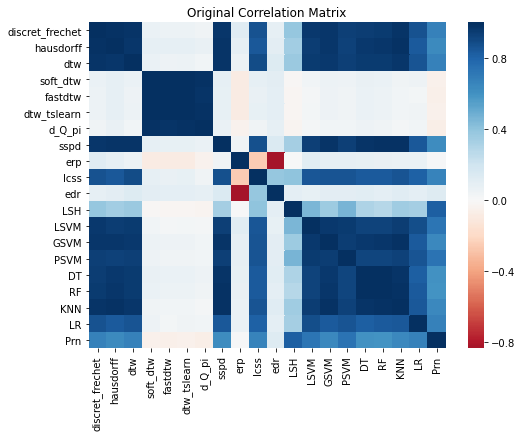

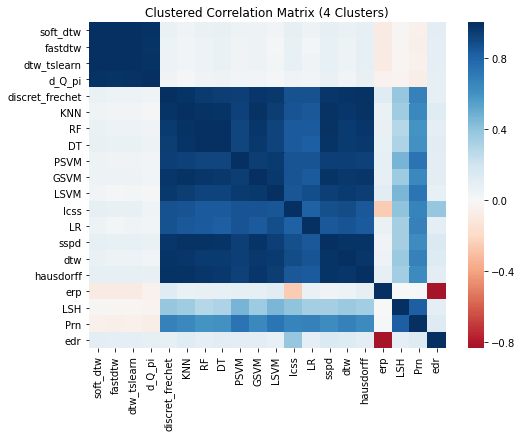

In [58]:
# This one should be used
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.cluster import SpectralCoclustering

distances = ['discret_frechet', 'hausdorff', 'dtw', 'soft_dtw', 'fastdtw', 'dtw_tslearn',
             'd_Q_pi', 'sspd', 'erp', 'lcss', 'edr', 'LSH']

classifiers = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'Prn']

path1 = 'Claculated test errors for correlation/Taxi/random_V_Q_errors.csv'
classifiers_errors = np.array(pd.read_csv(path1, header=None))

path2 = 'Claculated test errors for correlation/Taxi/KNN_test_errors.csv'
KNN_test_errors_11 = np.array(pd.read_csv(path2, header=None))

path3 = 'Claculated test errors for correlation/Taxi/KNN_LSH_test_errors_Taxi.csv'
KNN_LSH_test_errors = np.array(pd.read_csv(path3, header=None)).T

KNN_test_errors = np.concatenate((KNN_test_errors_11, KNN_LSH_test_errors), 0)

dataa = {distances[i]: KNN_test_errors[i] for i in range(len(distances))}
dataa1 = {classifiers[i]: classifiers_errors[:, i] for i in range(len(classifiers))}
dataa.update(dataa1)

columns = [distances[i] for i in range(len(distances))] + [classifiers[i] for i in range(len(classifiers))]
df = pd.DataFrame(dataa, columns=columns)
corrMatrix = df.corr()

plt.figure(figsize = (8, 6))
sn.heatmap(corrMatrix, annot=False, cmap='RdBu', center=0)
plt.title(f'Original Correlation Matrix')
#plt.savefig(f'Original-Correlation-Matrix.png', bbox_inches='tight', dpi=1200)
plt.show()


model = SpectralCoclustering(n_clusters=5, random_state=None)
model.fit(corrMatrix)

columns = np.array(distances + classifiers)[np.argsort(model.column_labels_)]

keys = []
values = []
for i in np.argsort(model.column_labels_):
    if i < len(distances):
        keys.append(distances[i])
        values.append(KNN_test_errors[i])
    else:
        keys.append(classifiers[i-len(distances)])
        values.append(classifiers_errors[:, i-len(distances)])
        
Dataa = {keys[i]: values[i] for i in range(len(keys))}
ddf = pd.DataFrame(Dataa, columns=columns)

plt.figure(figsize = (8, 6))
sn.heatmap(ddf.corr(), annot=False, cmap='RdBu', center=0)
plt.title(f'Clustered Correlation Matrix (4 Clusters)')
#plt.savefig(f'Clustered-Correlation-Matrix.png', bbox_inches='tight', dpi=1200)
plt.show()

In [59]:
corrMatrix

,discret_frechet,hausdorff,dtw,soft_dtw,fastdtw,dtw_tslearn,d_Q_pi,sspd,erp,lcss,edr,LSH,LSVM,GSVM,PSVM,DT,RF,KNN,LR,Prn
discret_frechet,1.000000,0.983806,0.974832,0.067109,0.056263,0.059793,0.043985,0.969304,0.121380,0.865742,0.088754,0.386643,0.962034,0.969069,0.942136,0.946924,0.953138,0.975772,0.865163,0.675815
hausdorff,0.983806,1.000000,0.970380,0.095057,0.085658,0.086398,0.072830,0.978095,0.093583,0.849227,0.110023,0.344774,0.946503,0.968598,0.932255,0.962861,0.965117,0.982875,0.839898,0.633520
dtw,0.974832,0.970380,1.000000,0.061848,0.049058,0.054790,0.037102,0.974169,0.058015,0.890549,0.134441,0.375283,0.954072,0.963581,0.941376,0.953965,0.953421,0.968855,0.860568,0.675871
soft_dtw,0.067109,0.095057,0.061848,1.000000,0.992763,0.998393,0.981051,0.086802,-0.080884,0.084344,0.105627,-0.016738,0.032921,0.058342,0.052418,0.071849,0.067074,0.045270,0.047825,-0.049993
fastdtw,0.056263,0.085658,0.049058,0.992763,1.000000,0.992850,0.974069,0.078927,-0.075441,0.071965,0.097837,-0.022678,0.019488,0.048452,0.041541,0.063986,0.060181,0.034977,0.030410,-0.055756
dtw_tslearn,0.059793,0.086398,0.054790,0.998393,0.992850,1.000000,0.982199,0.078554,-0.080989,0.075817,0.100082,-0.019128,0.028567,0.050823,0.046764,0.063987,0.060313,0.037553,0.042012,-0.051251
d_Q_pi,0.043985,0.072830,0.037102,0.981051,0.974069,0.982199,1.000000,0.066275,-0.043181,0.040129,0.083287,-0.028657,0.024032,0.035927,0.033287,0.050149,0.046064,0.022278,0.032550,-0.064387
sspd,0.969304,0.978095,0.974169,0.086802,0.078927,0.078554,0.066275,1.000000,0.044597,0.877406,0.142949,0.333909,0.939142,0.972994,0.936442,0.971380,0.978748,0.980409,0.844033,0.623859
erp,0.121380,0.093583,0.058015,-0.080884,-0.075441,-0.080989,-0.043181,0.044597,1.000000,-0.253532,-0.834725,0.005153,0.114603,0.087343,0.096112,0.081490,0.075384,0.065905,0.066421,0.017477
lcss,0.865742,0.849227,0.890549,0.084344,0.071965,0.075817,0.040129,0.877406,-0.253532,1.000000,0.390522,0.402950,0.853238,0.863273,0.859397,0.836024,0.839753,0.859622,0.818134,0.666290
